# Computation Intelligence for Optimization | Sports League Optimization

`Group AM`
- Eduardo Mendes, 20240850
- Helena Duarte, 20240530
- João Freire, 20240528
- Mariana Sousa, 20240516

<div class="alert alert-block alert-info">

# Table of Contents
    
[1. Import Libraries](#1)<br>

[2. Load data](#2)<br>

<a class="anchor" id="1">

# 1. Import Libraries
    
</a>

In [1]:
import os
import pandas as pd
import numpy as np


from copy import deepcopy
from random import random, sample, choice, randint
import copy

<a class="anchor" id="2">

# 2. Load data
    
</a>

In [2]:
#data_dir= os.path.join(os.getcwd(), 'players(in).csv')

# Read the CSV file into a DataFrame
df = pd.read_csv("players(in).csv", index_col=0)
df.head()

,Name,Position,Skill,Salary (€M)
0,Alex Carter,GK,85,90
1,Jordan Smith,GK,88,100
2,Ryan Mitchell,GK,83,85
3,Chris Thompson,GK,80,80
4,Blake Henderson,GK,87,95


<a class="anchor" id="3">

# 3. Problem Definiton
    
</a>

In a fantasy sports league, the objective is to assign players to teams in a way that ensures
a balanced distribution of talent while staying within salary caps.

1) Each player is defined by the following attributes:
* Skill rating: Represents the player's ability.
* Cost: The player's salary.
* Position (One of four roles) : Goalkeeper (GK), Defender (DEF), Midfielder (MID), or Forward (FWD).

A solution is a complete league configuration, specifying the team assignment for each player. These are the constraints that must be verified in every solution of the search space (no object is considered a solution if it doesn’t comply with these):
* Each team must consist of: 1 Goalkeeper, 2 Defenders, 2 Midfielders and 2
Forwards.
* Each player is assigned to exactly one team.

*Impossible Configurations*: Teams that do not follow this exact structure (e.g., a team with 2 goalkeepers, or a team where the same defender is assigned twice) are not part of the search space and are not considered solutions. It is forbidden to generate such an arrangement during evolution.

Besides that, each team should not exceed a 750€ million total budget. If it does, it is not a valid solution and the fitness value should reflect that.

The `objective` is to create a balanced league that complies with the constraints. 
A balanced league a is a league where the average skill rating of the players is roughly the same among the teams. 
This can be measured by the standard deviation of the average skill rating of the teams.

You can find a dataset of players with their names, position, skill rating and salary (in million €).
These players should be distributed across 5 teams of 7 players each.

# 4.Representação com classes player, team and League 

In [3]:
# change the column names to lowercase
df.rename(columns={
    "Name": "name",
    "Position": "position",
    "Skill": "skill",
    "Salary (€M)": "salary"
}, inplace=True)

In [4]:
df.head(10) # show the first 10 rows of the dataframe with the renamed columns

,name,position,skill,salary
0,Alex Carter,GK,85,90
1,Jordan Smith,GK,88,100
2,Ryan Mitchell,GK,83,85
3,Chris Thompson,GK,80,80
4,Blake Henderson,GK,87,95
5,Daniel Foster,DEF,90,110
6,Lucas Bennett,DEF,85,90
7,Owen Parker,DEF,88,100
8,Ethan Howard,DEF,80,70
9,Mason Reed,DEF,82,75


In [5]:
position_order = ["GK", "DEF", "MID", "FWD"] # the order of positions

# Create a mapping dictionary: {'GK': 0, 'DEF': 1, 'MID': 2, 'FWD': 3}
# x.map(...) converts each "position" value in the DataFrame to its corresponding order index
# Sorts the DataFrame according to these mapped indices
df_sorted = df.sort_values(by="position", key=lambda x: x.map({pos: i for i, pos in enumerate(position_order)})).reset_index(drop=True)
df_sorted.head(10)

,name,position,skill,salary
0,Alex Carter,GK,85,90
1,Jordan Smith,GK,88,100
2,Ryan Mitchell,GK,83,85
3,Chris Thompson,GK,80,80
4,Blake Henderson,GK,87,95
5,Daniel Foster,DEF,90,110
6,Lucas Bennett,DEF,85,90
7,Owen Parker,DEF,88,100
8,Ethan Howard,DEF,80,70
9,Mason Reed,DEF,82,75


In [6]:
# Create a column "id" in the sorted DataFrame
df_sorted["id"]= df_sorted.index

In [7]:
df_sorted.head(10)


,name,position,skill,salary,id
0,Alex Carter,GK,85,90,0
1,Jordan Smith,GK,88,100,1
2,Ryan Mitchell,GK,83,85,2
3,Chris Thompson,GK,80,80,3
4,Blake Henderson,GK,87,95,4
5,Daniel Foster,DEF,90,110,5
6,Lucas Bennett,DEF,85,90,6
7,Owen Parker,DEF,88,100,7
8,Ethan Howard,DEF,80,70,8
9,Mason Reed,DEF,82,75,9


In [8]:
# Create a list of players with their attributes, each player is a dictionary with their attributes, such as name, position, skill level and salary
dict_players = df_sorted.to_dict(orient="records")
dict_players



[{'name': 'Alex Carter', 'position': 'GK', 'skill': 85, 'salary': 90, 'id': 0},
 {'name': 'Jordan Smith',
  'position': 'GK',
  'skill': 88,
  'salary': 100,
  'id': 1},
 {'name': 'Ryan Mitchell',
  'position': 'GK',
  'skill': 83,
  'salary': 85,
  'id': 2},
 {'name': 'Chris Thompson',
  'position': 'GK',
  'skill': 80,
  'salary': 80,
  'id': 3},
 {'name': 'Blake Henderson',
  'position': 'GK',
  'skill': 87,
  'salary': 95,
  'id': 4},
 {'name': 'Daniel Foster',
  'position': 'DEF',
  'skill': 90,
  'salary': 110,
  'id': 5},
 {'name': 'Lucas Bennett',
  'position': 'DEF',
  'skill': 85,
  'salary': 90,
  'id': 6},
 {'name': 'Owen Parker',
  'position': 'DEF',
  'skill': 88,
  'salary': 100,
  'id': 7},
 {'name': 'Ethan Howard',
  'position': 'DEF',
  'skill': 80,
  'salary': 70,
  'id': 8},
 {'name': 'Mason Reed', 'position': 'DEF', 'skill': 82, 'salary': 75, 'id': 9},
 {'name': 'Logan Brooks',
  'position': 'DEF',
  'skill': 86,
  'salary': 95,
  'id': 10},
 {'name': 'Caleb Fisher

In [9]:
# The goal is to create a dict that maps each position ["GK", "DEF", "MID", "FWD"]
# to a list of player IDs who play that position — in the specific order: GK → DEF → MID → FWD

team_order= ["GK", "DEF", "MID", "FWD"]
team_grouped = df_sorted.groupby("position")["id"].apply(list) # in the end converts the group of ids to a list

# Create a dictionary that maps each position to its corresponding player IDs
position_id_map = {pos: team_grouped[pos] for pos in team_order if pos in team_grouped}

In [10]:
position_id_map

{'GK': [0, 1, 2, 3, 4],
 'DEF': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'MID': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
 'FWD': [25, 26, 27, 28, 29, 30, 31, 32, 33, 34]}

In [11]:
import random

* this is a possible function to generate one team, just to understand what we have to do

In [12]:
# create a function that generates a team from the dictionary of indices
def generate_team_indices(position_id_map):

    """
    Generates a valid sports team from a dictionary of player indices by position.

    This function randomly selects player indices to form a complete team that adheres
    to the required composition constraints:
    - 1 Goalkeeper (GK)
    - 2 Defenders (DEF)
    - 2 Midfielders (MID)
    - 2 Forwards (FWD)

    The selection is made from a dictionary (`position_id_map`) that maps each position
    to a list of available player indices. 
    
    Parameters:
        players (pd.DataFrame): A DataFrame containing player information (not used directly in this function).
        position_id_map (dict): A dictionary mapping positions ("GK", "DEF", "MID", "FWD")
                                to lists of available player indices.

    Returns:
        list: A list of player indices representing one valid team.

    """
    # generates a team from a dictionary of indices

    # Randomly select one valid team (just player indices)
    team = []
    team += random.sample(position_id_map["GK"], 1)  # Select 1 goalkeeper
    team += random.sample(position_id_map["DEF"], 2) # Select 2 defenders
    team += random.sample(position_id_map["MID"], 2) # Select 2 midfielders
    team += random.sample(position_id_map["FWD"], 2) # Select 2 forwards

    return team

In [13]:
position_id_map

{'GK': [0, 1, 2, 3, 4],
 'DEF': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'MID': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
 'FWD': [25, 26, 27, 28, 29, 30, 31, 32, 33, 34]}

In [14]:
team_indices = generate_team_indices(position_id_map)
team_indices

[0, 9, 13, 23, 19, 31, 34]

* this is a function to understand how to create a valid league

In [453]:
def generate_league(players):
    from copy import deepcopy
    import random
    num_teams=5
    
    # Step 1: Copy the player pool
    available_indices = list(range(len(players)))
    random.shuffle(available_indices)  # randomize pool to start
    
    # Step 2: Group indices by position
    def group_available(indices):
        from collections import defaultdict
        pos_map = defaultdict(list)
        for i in indices:
            pos_map[players[i]["position"]].append(i)
        return pos_map
    
    league = []

    for _ in range(num_teams):
        pos_to_indices = group_available(available_indices)

        # Check we still have enough players per role
        if (len(pos_to_indices["GK"]) < 1 or
            len(pos_to_indices["DEF"]) < 2 or
            len(pos_to_indices["MID"]) < 2 or
            len(pos_to_indices["FWD"]) < 2):
            raise ValueError("Not enough players left to form a complete team.")

        team = []
        team += random.sample(pos_to_indices["GK"], 1)
        team += random.sample(pos_to_indices["DEF"], 2)
        team += random.sample(pos_to_indices["MID"], 2)
        team += random.sample(pos_to_indices["FWD"], 2)

        # Remove these players from the available pool
        for idx in team:
            available_indices.remove(idx)

        league.append(team)

    return league


In [ ]:
league = generate_league(dict_players) 
league

[[0, 12, 9, 18, 15, 30, 26],
 [3, 5, 10, 20, 23, 34, 28],
 [2, 8, 13, 19, 21, 25, 29],
 [1, 11, 14, 16, 17, 27, 32],
 [4, 7, 6, 22, 24, 31, 33]]

# 5. SOLUTION REPRESENTATION

In [15]:
from abc import ABC, abstractmethod

In [16]:
class Solution(ABC):
    def __init__(self, repr=None):
        # To initialize a solution we need to know it's representation.
        # If no representation is given, a representation is randomly initialized.
        if repr == None:
            repr = self.random_initial_representation()
        # Attributes
        self.repr = repr

    # Method that is called when we run print(object of the class)
    def __repr__(self):
        return str(self.repr)

    # Other methods that must be implemented in subclasses
    @abstractmethod
    def fitness(self):
        pass

    @abstractmethod
    def random_initial_representation():
        pass


* this is the function we are going to use to generate a valid league

In [17]:
def generate_league(df):

    import random
    from collections import defaultdict
    
    num_teams=5
    available_ids = df.index.tolist()
    random.shuffle(available_ids)

    league = []

    for _ in range(num_teams):
        pos_map = defaultdict(list)

        # Build position map using current available players
        for i in available_ids:
            pos = df.loc[i, "position"]
            pos_map[pos].append(i)

        # Check we have enough players left per role
        if (len(pos_map["GK"]) < 1 or
            len(pos_map["DEF"]) < 2 or
            len(pos_map["MID"]) < 2 or
            len(pos_map["FWD"]) < 2):
            raise ValueError("Not enough players left to form a full team")

        # Select players for the team
        team = []
        team += random.sample(pos_map["GK"], 1)
        team += random.sample(pos_map["DEF"], 2)
        team += random.sample(pos_map["MID"], 2)
        team += random.sample(pos_map["FWD"], 2)

        # Remove them from pool
        for idx in team:
            available_ids.remove(idx)

        league.append(team)

    return league

In [ ]:
class SportsLeagueSolution(Solution):
    def __init__(self, repr=None, players_df=df_sorted):
        self.players_df = players_df
        super().__init__(repr=repr)

    
    def random_initial_representation(self):
        self.repr = generate_league(self.players_df)

        # Reset the 'team' column
        self.players_df["team"] = -1

        # Assign team number to each player
        for team_idx, team in enumerate(self.repr):
            self.players_df.loc[team, "team"] = team_idx

        return self.repr

    def fitness(self):
        team_avg_skills = []

        # Reset team column (optional safety)
        self.players_df["team"] = -1

        for team_idx, team in enumerate(self.repr):
            self.players_df.loc[team, "team"] = team_idx
            team_df = self.players_df.loc[team]

            total_salary = team_df["salary"].sum()
            if total_salary > 750:
                return 1e9  # Penalize invalid solution

            avg_skill = team_df["skill"].mean()
            team_avg_skills.append(avg_skill)

        # Minimize std deviation of team avg skills → balanced league
        return float(np.std(team_avg_skills))


In [19]:
sol1 = SportsLeagueSolution()
sol1

[[3, 6, 9, 17, 21, 31, 25], [4, 5, 10, 18, 20, 34, 27], [1, 12, 7, 19, 22, 26, 29], [0, 14, 11, 16, 24, 30, 28], [2, 13, 8, 23, 15, 32, 33]]

In [20]:
sol1.fitness()

0.7634508123364249

In [27]:
sol2 = SportsLeagueSolution()
sol2

[[0, 14, 13, 18, 17, 28, 32], [1, 6, 12, 23, 24, 34, 33], [2, 9, 8, 19, 20, 31, 29], [4, 10, 7, 16, 22, 26, 27], [3, 5, 11, 15, 21, 30, 25]]

In [28]:
sol2.repr

[[0, 14, 13, 18, 17, 28, 32],
 [1, 6, 12, 23, 24, 34, 33],
 [2, 9, 8, 19, 20, 31, 29],
 [4, 10, 7, 16, 22, 26, 27],
 [3, 5, 11, 15, 21, 30, 25]]

In [29]:
sol2.fitness()

0.5883217223421167

## Selector Algorithms

In [245]:

def tournament_selection(population, maximization = False):

    tournament_size = 4  # for now, it's just a fixed size of 5

    # Randomly sample individuals from population
    sample_population = random.sample(population, tournament_size)
    # Sort by fitness (lowest for minimization)
    sample_population.sort(key=lambda x: x.fitness(), reverse=maximization)

    return sample_population[0]
     

In [246]:
POP_SIZE = 50
initial_population = [
    SportsLeagueSolution()
    for _ in range(POP_SIZE)
]
initial_population

[[[0, 6, 7, 19, 15, 27, 30], [3, 9, 8, 24, 20, 33, 25], [4, 13, 14, 22, 23, 32, 29], [1, 10, 11, 18, 17, 26, 31], [2, 12, 5, 16, 21, 28, 34]],
 [[0, 11, 8, 23, 20, 26, 29], [1, 12, 14, 15, 19, 31, 32], [4, 7, 10, 22, 24, 27, 34], [2, 5, 13, 16, 17, 25, 33], [3, 6, 9, 21, 18, 30, 28]],
 [[4, 9, 6, 21, 23, 31, 29], [2, 7, 12, 16, 18, 34, 28], [3, 8, 11, 24, 19, 26, 25], [0, 5, 13, 17, 15, 33, 27], [1, 14, 10, 22, 20, 32, 30]],
 [[0, 7, 13, 19, 24, 25, 34], [4, 14, 10, 18, 17, 32, 30], [2, 8, 5, 21, 22, 28, 33], [1, 12, 6, 15, 23, 31, 26], [3, 9, 11, 20, 16, 29, 27]],
 [[3, 5, 9, 20, 21, 25, 31], [1, 14, 10, 17, 19, 27, 33], [2, 12, 11, 22, 16, 29, 34], [4, 7, 6, 15, 18, 26, 32], [0, 8, 13, 23, 24, 28, 30]],
 [[3, 10, 9, 15, 19, 29, 33], [1, 8, 7, 24, 16, 26, 34], [4, 12, 6, 20, 18, 28, 27], [2, 14, 13, 21, 23, 32, 31], [0, 11, 5, 17, 22, 25, 30]],
 [[2, 6, 9, 22, 18, 30, 29], [3, 11, 7, 23, 21, 28, 31], [1, 13, 5, 19, 20, 32, 27], [4, 8, 14, 15, 17, 25, 34], [0, 12, 10, 24, 16, 33, 26]],

In [253]:
tournament_selection(initial_population)

[[2, 10, 13, 24, 17, 26, 27], [1, 11, 6, 23, 22, 31, 32], [4, 8, 5, 18, 21, 33, 29], [0, 7, 14, 19, 20, 34, 28], [3, 12, 9, 16, 15, 25, 30]]

In [191]:
def ranking_selection(population, maximization=False):
    """
    Ranking selection based on linear rank probabilities.
    
    Args:
        population (list): A list of individuals in the population
    
    Returns:
        list or individual: The selected individual
    """
    sorted_population = sorted(population, key=lambda x: x.fitness(), reverse=True)
    n = len(population)
    ranks = list(range(1, n + 1))  # linear rank

    selected = random.choices(sorted_population, weights=ranks, k=1)
    return deepcopy(selected[0])

## Mutation Operators

Mutation types:

* PlayerSwap: Basic switch one player with another in the same position
* RoleShuffle: Choose a role, remove all players from that role, shuffle and re-atribute to teams
* PlayerRoleLeftShift: Select a player role (GK, DEF, MID, FWD) and shifts the players in that role to the left across teams, by a random number of positions

In [32]:
from abc import ABC, abstractmethod
from random import randint, shuffle, choice
from copy import deepcopy

In [33]:
class MutationOperator(ABC):
    @abstractmethod
    def mutate(self, solution):
        pass

In [ ]:
# class PlayerSwapMutation(MutationOperator):
#     def mutate(self, solution, verbose=False):
#         new_repr = deepcopy(solution.repr)

#         # Choose the id within the team of the player that will be swapped
#         player_to_swap = randint(0, 6)

#         # Choose the teams where the players will be swapped. Make sure they are different
#         team_to_swap_1 = randint(0, 4)
#         team_to_swap_2 = randint(0, 4)
#         while team_to_swap_1 == team_to_swap_2:
#             team_to_swap_2 = randint(0, 4)

#         if verbose:
#             # Extract player IDs before swap for accurate logging
#             pid1 = new_repr[team_to_swap_1][player_to_swap]
#             pid2 = new_repr[team_to_swap_2][player_to_swap]

#             print(f"Swapping player {pid1} from team {team_to_swap_1} "
#                 f"with player {pid2} from team {team_to_swap_2}")

#         # Swap players at the chosen index
#         new_repr[team_to_swap_1][player_to_swap], new_repr[team_to_swap_2][player_to_swap] = pid2, pid1

#         mutated = deepcopy(solution)
#         mutated.repr = new_repr
#         return mutated

In [34]:
def PlayerSwapMutation(self, solution, verbose=False):
        new_repr = deepcopy(solution.repr)

        # Choose the id within the team of the player that will be swapped
        player_to_swap = randint(0, 6)

        # Choose the teams where the players will be swapped. Make sure they are different
        team_to_swap_1 = randint(0, 4)
        team_to_swap_2 = randint(0, 4)
        while team_to_swap_1 == team_to_swap_2:
            team_to_swap_2 = randint(0, 4)

        if verbose:
            # Extract player IDs before swap for accurate logging
            pid1 = new_repr[team_to_swap_1][player_to_swap]
            pid2 = new_repr[team_to_swap_2][player_to_swap]

            print(f"Swapping player {pid1} from team {team_to_swap_1} "
                f"with player {pid2} from team {team_to_swap_2}")

        # Swap players at the chosen index
        new_repr[team_to_swap_1][player_to_swap], new_repr[team_to_swap_2][player_to_swap] = pid2, pid1

        mutated = deepcopy(solution)
        mutated.repr = new_repr
        return mutated

In [ ]:
import random
from copy import deepcopy

def player_swap_mutation(solution, verbose=False):
    """
    Applies player swap mutation to a SportsLeagueSolution representation.

    This mutation swaps players in the same position index between two different teams,
    preserving the positional structure of the team.

    Args:
        solution (object): A solution object of SportsLeagueSolution
        verbose (bool): Whether to print debug information.

    Returns:
        object: A mutated copy of the solution.
    """

    new_repr = deepcopy(solution.repr)

    # Choose the id within the team of the player that will be swapped
    player_to_swap = randint(0, 6)

    # Choose the teams where the players will be swapped. Make sure they are different
    team_to_swap_1 = randint(0, 4)
    team_to_swap_2 = randint(0, 4)
    while team_to_swap_1 == team_to_swap_2:
        team_to_swap_2 = randint(0, 4)

    if verbose:
        # Extract player IDs before swap for accurate logging
        pid1 = new_repr[team_to_swap_1][player_to_swap]
        pid2 = new_repr[team_to_swap_2][player_to_swap]

        print(f"Swapping player {pid1} from team {team_to_swap_1} "
            f"with player {pid2} from team {team_to_swap_2}")

    # Swap players at the chosen index
    new_repr[team_to_swap_1][player_to_swap], new_repr[team_to_swap_2][player_to_swap] = pid2, pid1

    mutated = deepcopy(solution)
    mutated.repr = new_repr
    return mutated




In [205]:
solution = SportsLeagueSolution()

print(f"Original Solution: {solution}")

new_solution_repr = player_swap_mutation(solution, verbose=True)

print(f"Mutated Solution: {new_solution_repr}")



Original Solution: [[0, 12, 10, 19, 23, 25, 30], [1, 6, 14, 15, 17, 29, 33], [2, 8, 7, 22, 18, 28, 26], [4, 11, 9, 24, 21, 32, 31], [3, 5, 13, 16, 20, 27, 34]]
Swapping player 3 (Team 4) with player 0 (Team 0) at position 0
Mutated Solution: [[3, 12, 10, 19, 23, 25, 30], [1, 6, 14, 15, 17, 29, 33], [2, 8, 7, 22, 18, 28, 26], [4, 11, 9, 24, 21, 32, 31], [0, 5, 13, 16, 20, 27, 34]]


In [48]:
# mutation = PlayerSwapMutation()
# original_repr = deepcopy(original_solution.repr) 
# mutated_solution = mutation.mutate(original_solution, verbose=True)

# print(f"Original Solution: {original_repr}")
# print(f"Mutated Solution: {mutated_solution}")

In [633]:
class RoleShuffleMutation(MutationOperator):
    def mutate(self, solution, verbose=False):
        new_repr = deepcopy(solution.repr)
        
        # Choose the role that will be affected
        # Remembering that the player IDs withing the team correspond to {"GK": 0, "DEF": [1, 2], "MID": [3, 4], "FWD": [5, 6]}
        i = randint(0, 6)
        if i in [1, 2]:
            i = [1, 2]
        elif i in [3, 4]:
            i = [3, 4]
        elif i in [5, 6]:
            i = [5, 6]
        else:
            i = [0]
        
        # If verbose, print the role and indexes being shuffled
        if verbose:
            role_map = {
                "GK": [0],
                "DEF": [1, 2],
                "MID": [3, 4],
                "FWD": [5, 6]
            }
            inv_map = {tuple(v): k for k, v in role_map.items()}
            role_name = inv_map[tuple(i)]
            print(f"Shuffling players in role {role_name}, corresponding to indexes {i}")


        # Remove all the players from the selected role and shuffle them
        bag_of_players = []
        for team in new_repr:
            bag_of_players += [team[i] for i in i]
            
        shuffle(bag_of_players)

        # Once shuffled, put them back in the teams
        index = 0
        for team in new_repr:
            for j in i:
                team[j] = bag_of_players[index]
                index += 1

        mutated = deepcopy(solution)
        mutated.repr = new_repr
        return mutated

In [52]:
def role_shuffle_mutation(solution, verbose=False):
    """
    Shuffles all players of the same role (e.g. all defenders) across teams.

    Args:
        solution (object): A solution object with a `.repr` attribute.
        verbose (bool): Whether to print debug info.

    Returns:
        object: A mutated copy of the solution.
    """
    new_repr = deepcopy(solution.repr)

    # Choose the role that will be affected
    # Remembering that the player IDs withing the team correspond to {"GK": 0, "DEF": [1, 2], "MID": [3, 4], "FWD": [5, 6]}
    i = randint(0, 6)
    if i in [1, 2]:
        i = [1, 2]
    elif i in [3, 4]:
        i = [3, 4]
    elif i in [5, 6]:
        i = [5, 6]
    else:
        i = [0]

    # If verbose, print the role and indexes being shuffled
    if verbose:
        role_map = {
            "GK": [0],
            "DEF": [1, 2],
            "MID": [3, 4],
            "FWD": [5, 6]
        }
        inv_map = {tuple(v): k for k, v in role_map.items()}
        role_name = inv_map[tuple(i)]
        print(f"Shuffling players in role {role_name}, corresponding to indexes {i}")

    # Remove all the players from the selected role and shuffle them
    bag_of_players = []
    for team in new_repr:
        bag_of_players += [team[i] for i in i]
        
    shuffle(bag_of_players)

    # Once shuffled, put them back in the teams
    index = 0
    for team in new_repr:
        for j in i:
            team[j] = bag_of_players[index]
            index += 1

    mutated = deepcopy(solution)
    mutated.repr = new_repr
    return mutated

In [210]:
original_solution = SportsLeagueSolution()

mutated_solution = role_shuffle_mutation(original_solution, verbose=True)

print(f"Original Solution: {original_solution}")
print(f"Mutated Solution: {mutated_solution}")

Shuffling players in role DEF, corresponding to indexes [1, 2]
Original Solution: [[4, 9, 7, 20, 21, 28, 32], [3, 14, 10, 19, 15, 25, 33], [0, 6, 11, 18, 17, 30, 26], [2, 13, 8, 24, 23, 31, 34], [1, 5, 12, 22, 16, 27, 29]]
Mutated Solution: [[4, 9, 8, 20, 21, 28, 32], [3, 10, 12, 19, 15, 25, 33], [0, 14, 5, 18, 17, 30, 26], [2, 11, 7, 24, 23, 31, 34], [1, 6, 13, 22, 16, 27, 29]]


In [63]:
# original_solution = SportsLeagueSolution(players_df=df_sorted)
# original_repr = deepcopy(original_solution.repr)  # Capture pre-mutation state

# mutation = RoleShuffleMutation()
# mutated_solution = mutation.mutate(original_solution, verbose=True)

# print(f"Original Solution: {original_repr}")
# print(f"Mutated Solution: {mutated_solution}")

In [637]:
class PlayerRoleLeftShiftMutation(MutationOperator):
    def mutate(self, solution, verbose=False):
        new_repr = deepcopy(solution.repr)

        # Choose the role that will be affected
        # Remembering that the player IDs withing the team correspond to {"GK": 0, "DEF": [1, 2], "MID": [3, 4], "FWD": [5, 6]}
        i = randint(0, 6)
        if i in [1, 2]:
            i = [1, 2]
        elif i in [3, 4]:
            i = [3, 4]
        elif i in [5, 6]:
            i = [5, 6]
        else:
            i = [0]
        
        # Get all the players from the selected role
        role_players = []
        for team in new_repr:
            for idx in i:
                role_players.append(team[idx])

        # Shift left 
        shift_amount = randint(1, len(new_repr) - 1)
        role_players = role_players[shift_amount:] + role_players[:shift_amount]
        
        # If verbose, print the role and indexes being shifted
        if verbose:
            role_map = {
                "GK": [0],
                "DEF": [1, 2],
                "MID": [3, 4],
                "FWD": [5, 6]
            }
            inv_map = {tuple(v): k for k, v in role_map.items()}
            role_name = inv_map[tuple(i)]
            print(f"Shifting role group {role_name}, corresponding to indexes {i}, by {shift_amount} positions")

        # Reassign to teams
        index = 0
        for team in new_repr:
            for idx in i:
                team[idx] = role_players[index]
                index += 1


        mutated = deepcopy(solution)
        mutated.repr = new_repr
        return mutated

In [69]:
from copy import deepcopy
from random import randint

def player_role_left_shift_mutation(solution, verbose=False):
    """
    Shifts all players of the same role (e.g., all defenders) leftward across teams.

    Args:
        solution (object): A solution object with a `.repr` attribute.
        verbose (bool): Whether to print debug info.

    Returns:
        object: A mutated copy of the solution.

    """
    new_repr = deepcopy(solution.repr)
    # Choose the role that will be affected
    # Remembering that the player IDs withing the team correspond to {"GK": 0, "DEF": [1, 2], "MID": [3, 4], "FWD": [5, 6]}
    i = randint(0, 6)
    if i in [1, 2]:
        i = [1, 2]
    elif i in [3, 4]:
        i = [3, 4]
    elif i in [5, 6]:
        i = [5, 6]
    else:
        i = [0]
    
    # Get all the players from the selected role
    role_players = []
    for team in new_repr:
        for idx in i:
            role_players.append(team[idx])

    # Shift left 
    shift_amount = randint(1, len(new_repr) - 1)
    role_players = role_players[shift_amount:] + role_players[:shift_amount]
    
    # If verbose, print the role and indexes being shifted
    if verbose:
        role_map = {
            "GK": [0],
            "DEF": [1, 2],
            "MID": [3, 4],
            "FWD": [5, 6]
        }
        inv_map = {tuple(v): k for k, v in role_map.items()}
        role_name = inv_map[tuple(i)]
        print(f"Shifting role group {role_name}, corresponding to indexes {i}, by {shift_amount} positions")

    # Reassign to teams
    index = 0
    for team in new_repr:
        for idx in i:
            team[idx] = role_players[index]
            index += 1


    mutated = deepcopy(solution)
    mutated.repr = new_repr
    return mutated

In [209]:
original_solution = SportsLeagueSolution()
mutated_solution = player_role_left_shift_mutation(original_solution, verbose=True)

print(f"Original Solution: {original_solution}")
print(f"Mutated Solution: {mutated_solution}")

Shifting role group MID, corresponding to indexes [3, 4], by 4 positions
Original Solution: [[0, 9, 8, 15, 20, 28, 29], [1, 14, 12, 19, 23, 34, 31], [4, 10, 5, 21, 16, 30, 33], [3, 13, 6, 24, 22, 27, 25], [2, 11, 7, 18, 17, 32, 26]]
Mutated Solution: [[0, 9, 8, 21, 16, 28, 29], [1, 14, 12, 24, 22, 34, 31], [4, 10, 5, 18, 17, 30, 33], [3, 13, 6, 15, 20, 27, 25], [2, 11, 7, 19, 23, 32, 26]]


In [71]:
# original_solution = SportsLeagueSolution(players_df=df_sorted)
# original_repr = deepcopy(original_solution.repr)  # Capture pre-mutation state

# mutation = PlayerRoleLeftShiftMutation()
# mutated_solution = mutation.mutate(original_solution, verbose=True)

# print(f"Original Solution: {original_repr}")
# print(f"Mutated Solution: {mutated_solution}")

## Crossover Operators

In [79]:
import random
from collections import defaultdict, Counter

def get_position_map(players_df):
    
    """
    Creates a mapping from player ID to their position.

    This function takes a DataFrame of players with at least two columns:
    'id' (unique player identifier) and 'position' (e.g., GK, DEF, MID, FWD),
    and returns a dictionary that maps each player ID to their respective position.

    Args:
        players_df (pd.DataFrame): A DataFrame containing player information,
                                   with 'id' and 'position' columns.

    Returns:
        dict: A dictionary mapping each player ID (int) to their position (str).
              Example: {0: 'GK', 1: 'DEF', 2: 'MID', ...}
    """
    return dict(zip(players_df['id'], players_df['position']))

def standard_crossover_with_position_repair(parent1, parent2, players_df, crossover_point=3):
    crossover_point=random.randint(1, len(parent1) - 1)
    position_map = get_position_map(players_df) # creates a mapping from player ID to their position
    all_players = set(players_df['id']) # creates a set of all players

    # Crossover on team level by the crossover point defined on the arguments
    offspring1 = parent1[:crossover_point] + parent2[crossover_point:]
    offspring2 = parent2[:crossover_point] + parent1[crossover_point:]

    # Position slots by index inside each team
    # we want to always keep the [GK, DEF, DEF, MID, MID, FWD, FWD] formatation
    position_slots = ["GK", "DEF", "DEF", "MID", "MID", "FWD", "FWD"] # players are assumed to always appear in this fixed order

    def repair_offspring(offspring):

        """
        Repairs an offspring by removing duplicate players and replacing 
        them with valid players that were missing from the solution.

        This function ensures:
            - Each player appears only once across all teams.
            - Players are only replaced by others who play the same position.
            - All players from the original player pool are used exactly once.

        The function relies on two external variables:
            - `all_players`: A set of all player IDs expected to be used in the solution.
            - `position_map`: A dictionary mapping player IDs to their positions (e.g., 'GK', 'DEF').
            - `position_slots`: A list defining the position expected at each slot in a team.

        Parameters:
            offspring (list of list of int): A candidate solution represented as a list of teams, 
                                            where each team is a list of player IDs.

        Returns:
            list of list of int: A repaired version of the offspring, where:
                                - All players are unique.
                                - Each player is placed in a slot matching their position.
                                - Missing players are added in valid positions.

        Notes:
            The function modifies teams independently, attempting to replace invalid entries
            (duplicates or misplaced players) with players not yet used but suitable for
            the expected position.
        """
        
        # receives an offspring, thelist of teams and it returns a "repaired" version where:
            # * All players are unique, so no duplicates across teams, that is a problem with the standard crossover
            # * Players are replaced only with others of the same position
            # * Any missing players are added back.


        # Flatten all players used
        flat = [p for team in offspring for p in team] # Flattens the list of teams into a single list of all player IDs
        counts = Counter(flat) # Count occurrences of each player ID ( how many times each player appears in the flattened offspring)

        # Find duplicates and missing players
        duplicates = {p for p, c in counts.items() if c > 1} # get the players that appear more than once
        used = set(flat) # get the players that are used in the offspring
        missing = list(all_players - used) # get the players that are missing in the offspring but should be there (all players come from above code)
        
        # Build available players by position for replacements

        available_by_pos = defaultdict(list)  # create a dict where the key is a position  and the value is a shuffled list of player IDs that are available for that position
        for pid in missing: # for each player ID in the missing list
            pos = position_map[pid] # get the position of the player
            available_by_pos[pos].append(pid) # append the player ID to the list of available players for that position
        for pos in available_by_pos: # for each position in the available players
            random.shuffle(available_by_pos[pos]) # shuffle the list of available players for that position

        # Track used players to avoid duplicates
        used_players = set() #  tracks player IDs that have already been added to teams to prevent further duplicates during the repair process
        repaired_offspring = [] 
        for team in offspring: # for each team in the offspring
            new_team = [] # create a new team
            for idx, pid in enumerate(team): # for each player ID in the team
                pos = position_slots[idx] # get the position of the player based on the index

                # If player is duplicated or already used, replace
                if pid in used_players or pid in duplicates: # if the player ID is already used or is a duplicate
                    if available_by_pos[pos]: # if there are available players for that position
                        replacement = available_by_pos[pos].pop() # get a replacement player ID from the available players for that position
                        new_team.append(replacement) # add the replacement player ID to the new team
                        used_players.add(replacement) # add the replacement player ID to the used players
                    else:
                        # If no available players left in that position (should not happen), keep original
                        new_team.append(pid) # add the original player ID to the new team
                        used_players.add(pid) # add the original player ID to the used players
                else: # if the player ID is not a duplicate and not already used
                    new_team.append(pid) # add the original player ID to the new team
                    used_players.add(pid) # add the original player ID to the used players

            repaired_offspring.append(new_team) # add the new team to the repaired offspring
        return repaired_offspring

    return repair_offspring(offspring1), repair_offspring(offspring2)


In [38]:
sol1 = SportsLeagueSolution()
sol1

[[0, 12, 11, 22, 20, 27, 28], [2, 6, 7, 21, 24, 34, 30], [3, 14, 8, 15, 18, 33, 25], [1, 9, 13, 19, 23, 29, 32], [4, 10, 5, 16, 17, 26, 31]]

In [39]:
sol2 = SportsLeagueSolution()
sol2

[[3, 13, 9, 19, 22, 26, 33], [0, 6, 8, 18, 24, 29, 28], [4, 11, 10, 17, 15, 25, 30], [1, 12, 7, 20, 16, 27, 34], [2, 5, 14, 23, 21, 31, 32]]

In [40]:
sol1.repr

[[0, 12, 11, 22, 20, 27, 28],
 [2, 6, 7, 21, 24, 34, 30],
 [3, 14, 8, 15, 18, 33, 25],
 [1, 9, 13, 19, 23, 29, 32],
 [4, 10, 5, 16, 17, 26, 31]]

In [41]:
sol2.repr

[[3, 13, 9, 19, 22, 26, 33],
 [0, 6, 8, 18, 24, 29, 28],
 [4, 11, 10, 17, 15, 25, 30],
 [1, 12, 7, 20, 16, 27, 34],
 [2, 5, 14, 23, 21, 31, 32]]

In [42]:
offspring1, offspring2 = standard_crossover_with_position_repair(sol1.repr, sol2.repr, df_sorted)

In [43]:
offspring1

[[0, 12, 11, 22, 20, 27, 28],
 [4, 6, 7, 17, 24, 34, 30],
 [3, 10, 8, 15, 18, 33, 25],
 [1, 9, 13, 19, 16, 29, 26],
 [2, 5, 14, 23, 21, 31, 32]]

In [161]:
def validate_league(league, players_df, position_slots = ["GK", "DEF", "DEF", "MID", "MID", "FWD", "FWD"]):
    """
    Validates a league composed of multiple teams.

    Requirements checked:
        - Each player appears exactly once across all teams (no duplicates or missing).
        - Players are placed in the correct position slot according to position_slots.
        - Each team has the correct number of players.

    Parameters:
        league (list of list of int): The league to validate, as a list of teams (each a list of player IDs).
        players_df (pd.DataFrame): DataFrame with at least 'id' and 'position' columns.
        position_slots (list of str): Expected position at each index of a team, e.g., 
                                      ["GK", "DEF", "DEF", "MID", "MID", "FWD", "FWD"]

    Returns:
        bool: True if the league is valid. Otherwise, prints detailed issues and returns False.
    """
    from collections import Counter

    all_player_ids = set(players_df['id'])
    expected_team_size = len(position_slots)

    # 1. Check total number of players
    flat_players = [p for team in league for p in team]
    player_counts = Counter(flat_players)

    # Check if every player is used exactly once
    if set(flat_players) != all_player_ids:
        missing = all_player_ids - set(flat_players)
        extra = set(flat_players) - all_player_ids
        if missing:
            print(f"Missing players: {missing}")
        if extra:
            print(f"Unknown players found: {extra}")
        return False

    duplicates = {p for p, c in player_counts.items() if c > 1}
    if duplicates:
        print(f"Duplicated players: {duplicates}")
        return False

    # 2. Check team structure and position integrity
    position_map = dict(zip(players_df['id'], players_df['position']))
    for i, team in enumerate(league):
        if len(team) != expected_team_size:
            print(f"Team {i} has invalid size {len(team)}. Expected {expected_team_size}.")
            return False
        for idx, pid in enumerate(team):
            expected_pos = position_slots[idx]
            actual_pos = position_map.get(pid)
            if actual_pos != expected_pos:
                print(f"Team {i}, player {pid} in slot {idx} expected {expected_pos}, got {actual_pos}.")
                return False

    print("League is valid!")
    return True


### A lot of examples

In [481]:
sol1 = SportsLeagueSolution()
sol2 = SportsLeagueSolution()
sol3 = SportsLeagueSolution()
sol4 = SportsLeagueSolution()
sol5 = SportsLeagueSolution()
sol6 = SportsLeagueSolution()
sol7 = SportsLeagueSolution()
sol8 = SportsLeagueSolution()
sol9 = SportsLeagueSolution()
sol10 = SportsLeagueSolution()

In [520]:
sol1.repr

[[1, 6, 12, 15, 23, 31, 26],
 [3, 13, 9, 19, 21, 25, 32],
 [2, 10, 8, 20, 18, 27, 28],
 [0, 7, 5, 17, 22, 29, 30],
 [4, 11, 14, 16, 24, 33, 34]]

In [524]:
sol1.fitness()

np.float64(1.6373198607879287)

In [482]:
offspring1, offspring2 = standard_crossover_with_position_repair(sol1.repr, sol2.repr, df_sorted)
offspring3, offspring4 = standard_crossover_with_position_repair(sol1.repr, sol3.repr, df_sorted)
offspring5, offspring6 = standard_crossover_with_position_repair(sol1.repr, sol4.repr, df_sorted)
offspring7, offspring8 = standard_crossover_with_position_repair(sol1.repr, sol5.repr, df_sorted)
offspring9, offspring10 = standard_crossover_with_position_repair(sol1.repr, sol6.repr, df_sorted)

offspring11, offspring12 = standard_crossover_with_position_repair(sol1.repr, sol7.repr, df_sorted)
offspring13, offspring14 = standard_crossover_with_position_repair(sol1.repr, sol8.repr, df_sorted)
offspring15, offspring16 = standard_crossover_with_position_repair(sol1.repr, sol9.repr, df_sorted)
offspring17, offspring18 = standard_crossover_with_position_repair(sol1.repr, sol10.repr, df_sorted)
offspring19, offspring20 = standard_crossover_with_position_repair(sol2.repr, sol3.repr, df_sorted)

offspring21, offspring22 = standard_crossover_with_position_repair(sol2.repr, sol4.repr, df_sorted)
offspring23, offspring24 = standard_crossover_with_position_repair(sol2.repr, sol5.repr, df_sorted)
offspring25, offspring26 = standard_crossover_with_position_repair(sol2.repr, sol6.repr, df_sorted)
offspring27, offspring28 = standard_crossover_with_position_repair(sol2.repr, sol7.repr, df_sorted)
offspring29, offspring30 = standard_crossover_with_position_repair(sol2.repr, sol8.repr, df_sorted)

offspring31, offspring32 = standard_crossover_with_position_repair(sol2.repr, sol9.repr, df_sorted)
offspring33, offspring34 = standard_crossover_with_position_repair(sol2.repr, sol10.repr, df_sorted)
offspring35, offspring36 = standard_crossover_with_position_repair(sol3.repr, sol4.repr, df_sorted)
offspring37, offspring38 = standard_crossover_with_position_repair(sol3.repr, sol5.repr, df_sorted)
offspring39, offspring40 = standard_crossover_with_position_repair(sol3.repr, sol6.repr, df_sorted)

offspring41, offspring42 = standard_crossover_with_position_repair(sol3.repr, sol7.repr, df_sorted)
offspring43, offspring44 = standard_crossover_with_position_repair(sol3.repr, sol8.repr, df_sorted)
offspring45, offspring46 = standard_crossover_with_position_repair(sol3.repr, sol9.repr, df_sorted)
offspring47, offspring48 = standard_crossover_with_position_repair(sol3.repr, sol10.repr, df_sorted)
offspring49, offspring50 = standard_crossover_with_position_repair(sol4.repr, sol5.repr, df_sorted)

offspring51, offspring52 = standard_crossover_with_position_repair(sol4.repr, sol6.repr, df_sorted)
offspring53, offspring54 = standard_crossover_with_position_repair(sol4.repr, sol7.repr, df_sorted)
offspring55, offspring56 = standard_crossover_with_position_repair(sol4.repr, sol8.repr, df_sorted)
offspring57, offspring58 = standard_crossover_with_position_repair(sol4.repr, sol9.repr, df_sorted)
offspring59, offspring60 = standard_crossover_with_position_repair(sol4.repr, sol10.repr, df_sorted)

offspring61, offspring62 = standard_crossover_with_position_repair(sol5.repr, sol6.repr, df_sorted)
offspring63, offspring64 = standard_crossover_with_position_repair(sol5.repr, sol7.repr, df_sorted)
offspring65, offspring66 = standard_crossover_with_position_repair(sol5.repr, sol8.repr, df_sorted)
offspring67, offspring68 = standard_crossover_with_position_repair(sol5.repr, sol9.repr, df_sorted)
offspring69, offspring70 = standard_crossover_with_position_repair(sol5.repr, sol10.repr, df_sorted)

offspring71, offspring72 = standard_crossover_with_position_repair(sol6.repr, sol7.repr, df_sorted)
offspring73, offspring74 = standard_crossover_with_position_repair(sol6.repr, sol8.repr, df_sorted)
offspring75, offspring76 = standard_crossover_with_position_repair(sol6.repr, sol9.repr, df_sorted)
offspring77, offspring78 = standard_crossover_with_position_repair(sol6.repr, sol10.repr, df_sorted)
offspring79, offspring80 = standard_crossover_with_position_repair(sol7.repr, sol8.repr, df_sorted)

offspring81, offspring82 = standard_crossover_with_position_repair(sol7.repr, sol9.repr, df_sorted)
offspring83, offspring84 = standard_crossover_with_position_repair(sol7.repr, sol10.repr, df_sorted)
offspring85, offspring86 = standard_crossover_with_position_repair(sol8.repr, sol9.repr, df_sorted)
offspring87, offspring88 = standard_crossover_with_position_repair(sol8.repr, sol10.repr, df_sorted)
offspring89, offspring90 = standard_crossover_with_position_repair(sol9.repr, sol10.repr, df_sorted)

In [483]:
print(validate_league(offspring1, df_sorted))
print(validate_league(offspring2, df_sorted))
print(validate_league(offspring3, df_sorted))
print(validate_league(offspring4, df_sorted))
print(validate_league(offspring5, df_sorted))
print(validate_league(offspring6, df_sorted))
print(validate_league(offspring7, df_sorted))
print(validate_league(offspring8, df_sorted))
print(validate_league(offspring9, df_sorted))
print(validate_league(offspring10, df_sorted))


League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True


In [484]:
print(validate_league(offspring11, df_sorted))
print(validate_league(offspring12, df_sorted))
print(validate_league(offspring13, df_sorted))
print(validate_league(offspring14, df_sorted))
print(validate_league(offspring15, df_sorted))
print(validate_league(offspring16, df_sorted))
print(validate_league(offspring17, df_sorted))
print(validate_league(offspring18, df_sorted))
print(validate_league(offspring19, df_sorted))
print(validate_league(offspring20, df_sorted))

League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True


In [485]:
print(validate_league(offspring21, df_sorted))
print(validate_league(offspring22, df_sorted))
print(validate_league(offspring23, df_sorted))
print(validate_league(offspring24, df_sorted))
print(validate_league(offspring25, df_sorted))
print(validate_league(offspring26, df_sorted))
print(validate_league(offspring27, df_sorted))
print(validate_league(offspring28, df_sorted))
print(validate_league(offspring29, df_sorted))
print(validate_league(offspring30, df_sorted))

League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True


In [486]:
print(validate_league(offspring31, df_sorted))
print(validate_league(offspring32, df_sorted))
print(validate_league(offspring33, df_sorted))
print(validate_league(offspring34, df_sorted))
print(validate_league(offspring35, df_sorted))
print(validate_league(offspring36, df_sorted))
print(validate_league(offspring37, df_sorted))
print(validate_league(offspring38, df_sorted))
print(validate_league(offspring39, df_sorted))
print(validate_league(offspring40, df_sorted))

League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True


In [487]:
print(validate_league(offspring41, df_sorted))
print(validate_league(offspring42, df_sorted))
print(validate_league(offspring43, df_sorted))
print(validate_league(offspring44, df_sorted))
print(validate_league(offspring45, df_sorted))
print(validate_league(offspring46, df_sorted))
print(validate_league(offspring47, df_sorted))
print(validate_league(offspring48, df_sorted))
print(validate_league(offspring49, df_sorted))
print(validate_league(offspring50, df_sorted))


League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True


In [488]:
print(validate_league(offspring51, df_sorted))
print(validate_league(offspring52, df_sorted))
print(validate_league(offspring53, df_sorted))
print(validate_league(offspring54, df_sorted))
print(validate_league(offspring55, df_sorted))
print(validate_league(offspring56, df_sorted))
print(validate_league(offspring57, df_sorted))
print(validate_league(offspring58, df_sorted))
print(validate_league(offspring59, df_sorted))
print(validate_league(offspring60, df_sorted))

League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True


In [489]:
print(validate_league(offspring61, df_sorted))
print(validate_league(offspring62, df_sorted))
print(validate_league(offspring63, df_sorted))
print(validate_league(offspring64, df_sorted))
print(validate_league(offspring65, df_sorted))
print(validate_league(offspring66, df_sorted))
print(validate_league(offspring67, df_sorted))
print(validate_league(offspring68, df_sorted))
print(validate_league(offspring69, df_sorted))
print(validate_league(offspring70, df_sorted))

League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True


In [490]:
print(validate_league(offspring71, df_sorted))
print(validate_league(offspring72, df_sorted))
print(validate_league(offspring73, df_sorted))
print(validate_league(offspring74, df_sorted))
print(validate_league(offspring75, df_sorted))
print(validate_league(offspring76, df_sorted))
print(validate_league(offspring77, df_sorted))
print(validate_league(offspring78, df_sorted))
print(validate_league(offspring79, df_sorted))
print(validate_league(offspring80, df_sorted))

League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True


In [491]:
print(validate_league(offspring81, df_sorted))
print(validate_league(offspring82, df_sorted))
print(validate_league(offspring83, df_sorted))
print(validate_league(offspring84, df_sorted))
print(validate_league(offspring85, df_sorted))
print(validate_league(offspring86, df_sorted))
print(validate_league(offspring87, df_sorted))
print(validate_league(offspring88, df_sorted))
print(validate_league(offspring89, df_sorted))
print(validate_league(offspring90, df_sorted))

League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True
League is valid!
True


# outro crossover

* acho que tinhamos ontem falado num crossover onde mantinhos todos os jogadores de 2 posições do pai 1 e dps adicionavamos todos os jogadores das restantes 2 posições do pai 2, portanto, era crossover de "posições"
E isto podia ser feito para vários numeros, do pai1 mantemos os jogadores que sao GK, e juntamos os DEF, MID, FWD do pai2, ou do pai31 
mantemos os jogadores que sao GK e MID e juntamos os DEF, FWD do pai2

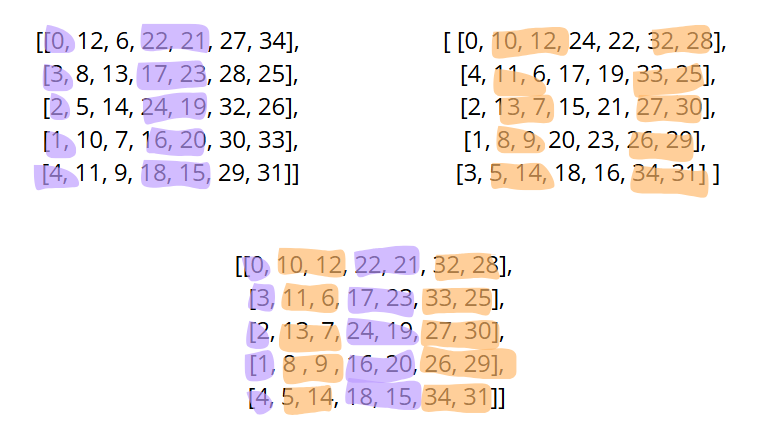

* first function of this type

In [80]:
from collections import defaultdict

def crossover_by_position(parent1, parent2, players_df, keep_positions=["GK", "MID"]):
    """
    Performs a role-aware crossover where selected positions are preserved from parent1,
    and the rest are filled from parent2. Each team is composed of 7 players in this order:
    [GK, DEF, DEF, MID, MID, FWD, FWD]

    Args:
        parent1 (list of list of int): First parent (5 teams × 7 players).
        parent2 (list of list of int): Second parent (5 teams × 7 players).
        players_df (pd.DataFrame): DataFrame with 'id' and 'position' columns.
        keep_positions (list): List of position names to keep from parent1.

    Returns:
        list: A new offspring created by crossover of parent1 and parent2 based on positions.
    """
    position_map = dict(zip(players_df['id'], players_df['position']))
    position_slots = ["GK", "DEF", "DEF", "MID", "MID", "FWD", "FWD"]

    used_players = set()
    offspring = []

    for team_idx in range(5):
        team1 = parent1[team_idx]
        team2 = parent2[team_idx]

        new_team = [None] * 7

        # Step 1: Keep players from parent1 in desired positions
        for i, slot in enumerate(position_slots):
            pid1 = team1[i]
            if position_map[pid1] == slot and slot in keep_positions:
                new_team[i] = pid1
                used_players.add(pid1)

        # Step 2: Fill the remaining positions from parent2 with correct role and no duplicates
        for i, slot in enumerate(position_slots):
            if new_team[i] is not None:
                continue  # already filled from parent1

            for pid2 in team2:
                if (
                    pid2 not in used_players
                    and position_map[pid2] == slot
                    and (slot not in keep_positions)
                ):
                    new_team[i] = pid2
                    used_players.add(pid2)
                    break

        # Step 3: Fallback (if not filled — shouldn't happen if parents are valid)
        for i, slot in enumerate(position_slots):
            if new_team[i] is None:
                # Search all players of that position not yet used
                for pid in players_df[players_df["position"] == slot]["id"]:
                    if pid not in used_players:
                        new_team[i] = pid
                        used_players.add(pid)
                        break

        offspring.append(new_team)

    return offspring


In [493]:
exe1 = SportsLeagueSolution()
exe1.repr

[[2, 10, 14, 15, 21, 30, 26],
 [3, 13, 6, 19, 16, 34, 32],
 [1, 12, 9, 22, 24, 27, 31],
 [0, 11, 7, 18, 20, 25, 29],
 [4, 5, 8, 23, 17, 28, 33]]

In [494]:
exe2 = SportsLeagueSolution()
exe2.repr

[[3, 13, 11, 21, 19, 26, 33],
 [4, 8, 7, 16, 17, 34, 31],
 [0, 10, 14, 18, 24, 32, 28],
 [1, 5, 6, 23, 20, 29, 27],
 [2, 9, 12, 15, 22, 25, 30]]

In [495]:
res= crossover_by_position(parent1=exe1.repr, parent2=exe2.repr, players_df=df_sorted)

In [496]:
res

[[2, 13, 11, 15, 21, 26, 33],
 [3, 8, 7, 19, 16, 34, 31],
 [1, 10, 14, 22, 24, 32, 28],
 [0, 5, 6, 18, 20, 29, 27],
 [4, 9, 12, 23, 17, 25, 30]]

In [497]:
validate_league(res, df_sorted)

League is valid!


True

* second function

In [81]:
def crossover_by_position_dual(parent1, parent2, players_df, keep_positions=["GK", "MID"]):
    """
    Dual crossover:
    - Offspring1 keeps selected positions from parent1, fills rest from parent2.
    - Offspring2 keeps selected positions from parent2, fills rest from parent1.

    Each team: [GK, DEF, DEF, MID, MID, FWD, FWD]

    Args:
        parent1 (list of list of int): First parent (5 teams × 7 players).
        parent2 (list of list of int): Second parent (5 teams × 7 players).
        players_df (pd.DataFrame): DataFrame with 'id' and 'position' columns.
        keep_positions (list): Positions to keep from each parent.

    Returns:
        tuple: (offspring1, offspring2)
    """
    position_map = dict(zip(players_df['id'], players_df['position'])) # maps each player_id to its position ( 33 → "FWD").
    position_slots = ["GK", "DEF", "DEF", "MID", "MID", "FWD", "FWD"] # expected order of players in a team

    def make_offspring(primary, secondary):

        # build one offspring using:
        # * primary parent — the parent to preserve roles 
        # * secondary — the parent to fill the rest from.

        used_players = set() # player IDs that have already been added to teams to prevent  duplicates during the repair process
        offspring = [] # list to store the new teams

        for team_idx in range(5):
            team1 = primary[team_idx] # team1 is the primary parent
            team2 = secondary[team_idx] # team2 is the secondary parent
            new_team = [None] * 7 # create a new team with 7 empty slots

            # KKeep selected positions from primary
            for i, slot in enumerate(position_slots): # for each position in the team
                pid1 = team1[i] # get the player ID from the primary parent
                if position_map[pid1] == slot and slot in keep_positions: # if the player ID is in the correct position and is one of the positions to keep
                    new_team[i] = pid1 # add the player ID to the new team
                    used_players.add(pid1) # add the player ID to the used players

            # Fill remaining from secondary
            for i, slot in enumerate(position_slots): # for each position in the team
                if new_team[i] is not None: # if the position is already filled from the primary parent
                    continue
                for pid2 in team2: # for each player ID in the secondary parent
                    if ( 
                        pid2 not in used_players # if the player ID is not already used
                        and position_map[pid2] == slot # if the player ID is in the correct position
                        and slot not in keep_positions # if the position is not one of the positions to keep
                    ):
                        new_team[i] = pid2 # add the player ID to the new team
                        used_players.add(pid2) # add the player ID to the used players
                        break

            # By the type of crossover, we should not never use this part, but just in case things dont work as expected
            for i, slot in enumerate(position_slots):
                if new_team[i] is None:
                    for pid in players_df[players_df["position"] == slot]["id"]:
                        if pid not in used_players:
                            new_team[i] = pid
                            used_players.add(pid)
                            break

            offspring.append(new_team)

        return offspring

    offspring1 = make_offspring(parent1, parent2)
    offspring2 = make_offspring(parent2, parent1)
    return offspring1, offspring2


In [499]:
exe1 = SportsLeagueSolution()
exe1.repr

[[2, 12, 11, 23, 19, 25, 32],
 [1, 9, 5, 15, 24, 28, 26],
 [0, 14, 8, 16, 21, 30, 29],
 [3, 7, 10, 17, 18, 31, 33],
 [4, 6, 13, 20, 22, 34, 27]]

In [500]:
exe2 = SportsLeagueSolution()
exe2.repr

[[1, 7, 9, 15, 20, 33, 28],
 [2, 13, 5, 17, 21, 32, 25],
 [3, 10, 8, 23, 16, 27, 31],
 [4, 11, 14, 19, 22, 30, 26],
 [0, 6, 12, 18, 24, 34, 29]]

In [501]:
offspring11, offspring12 = crossover_by_position_dual(exe1.repr, exe2.repr, df_sorted)

In [502]:
offspring11

[[2, 7, 9, 23, 19, 33, 28],
 [1, 13, 5, 15, 24, 32, 25],
 [0, 10, 8, 16, 21, 27, 31],
 [3, 11, 14, 17, 18, 30, 26],
 [4, 6, 12, 20, 22, 34, 29]]

In [417]:
offspring12

[[0, 9, 7, 23, 24, 32, 25],
 [4, 13, 8, 22, 18, 31, 34],
 [2, 14, 11, 19, 17, 30, 27],
 [1, 5, 10, 21, 20, 26, 28],
 [3, 6, 12, 16, 15, 29, 33]]

In [503]:
exe1 = SportsLeagueSolution()
exe2 = SportsLeagueSolution()
exe3 = SportsLeagueSolution()
exe4 = SportsLeagueSolution()
exe5 = SportsLeagueSolution()
exe6 = SportsLeagueSolution()
exe7 = SportsLeagueSolution()
exe8 = SportsLeagueSolution()
exe9 = SportsLeagueSolution()
exe10 = SportsLeagueSolution()

In [504]:
offspring1, offspring2 = crossover_by_position_dual(exe1.repr, exe2.repr, df_sorted)
offspring3, offspring4 = crossover_by_position_dual(exe1.repr, exe3.repr, df_sorted)
offspring5, offspring6 = crossover_by_position_dual(exe1.repr, exe4.repr, df_sorted)
offspring7, offspring8 = crossover_by_position_dual(exe1.repr, exe5.repr, df_sorted)
offspring9, offspring10 = crossover_by_position_dual(exe1.repr, exe6.repr, df_sorted)




In [505]:
exe1.repr

[[1, 10, 8, 21, 19, 34, 28],
 [0, 7, 12, 22, 18, 30, 25],
 [3, 6, 11, 17, 16, 29, 33],
 [4, 5, 9, 24, 20, 27, 26],
 [2, 14, 13, 15, 23, 32, 31]]

In [506]:
exe2.repr

[[3, 5, 6, 23, 18, 27, 28],
 [2, 8, 13, 19, 21, 26, 33],
 [1, 12, 9, 20, 24, 25, 34],
 [4, 7, 14, 17, 22, 32, 30],
 [0, 10, 11, 16, 15, 31, 29]]

In [507]:
offspring1

[[1, 5, 6, 21, 19, 27, 28],
 [0, 8, 13, 22, 18, 26, 33],
 [3, 12, 9, 17, 16, 25, 34],
 [4, 7, 14, 24, 20, 32, 30],
 [2, 10, 11, 15, 23, 31, 29]]

In [508]:
offspring2

[[3, 10, 8, 23, 18, 34, 28],
 [2, 7, 12, 19, 21, 30, 25],
 [1, 6, 11, 20, 24, 29, 33],
 [4, 5, 9, 17, 22, 27, 26],
 [0, 14, 13, 16, 15, 32, 31]]

* third and last function, with a lot of random decisions -> maybe not good for this

In [685]:
# import random

# def crossover_by_position_dual(parent1, parent2, players_df, keep_positions=["GK", "DEF"], random_keep=False, num_keep_positions=2):
#     """
#     Dual crossover:
#     - Offspring1 keeps selected positions from parent1, fills rest from parent2.
#     - Offspring2 keeps selected positions from parent2, fills rest from parent1.

#     Each team: [GK, DEF, DEF, MID, MID, FWD, FWD]

#     Args:
#         parent1 (list of list of int): First parent (5 teams × 7 players).
#         parent2 (list of list of int): Second parent (5 teams × 7 players).
#         players_df (pd.DataFrame): DataFrame with 'id' and 'position' columns.
#         keep_positions (list): Positions to keep from each parent (overrides randomness).
#         random_keep (bool): If True, randomly choose positions to keep.
#         num_keep_positions (int): Number of positions to randomly select if random_keep=True.

#     Returns:
#         tuple: (offspring1, offspring2, selected_positions)
#     """
#     position_map = dict(zip(players_df['id'], players_df['position']))
#     position_slots = ["GK", "DEF", "DEF", "MID", "MID", "FWD", "FWD"]
#     all_positions = ["GK", "DEF", "MID", "FWD"]

#     if random_keep:
#         keep_positions = random.sample(all_positions, num_keep_positions)

#     def crossover_team(team_primary, team_secondary, keep_positions, used_players):
#         new_team = [None] * 7

#         # Step 1: Keep selected positions from primary parent
#         for i, slot in enumerate(position_slots):
#             pid = team_primary[i]
#             if position_map[pid] == slot and slot in keep_positions:
#                 new_team[i] = pid
#                 used_players.add(pid)

#         # Step 2: Fill remaining from secondary parent
#         for i, slot in enumerate(position_slots):
#             if new_team[i] is not None:
#                 continue
#             for pid in team_secondary:
#                 if pid not in used_players and position_map[pid] == slot and slot not in keep_positions:
#                     new_team[i] = pid
#                     used_players.add(pid)
#                     break

#         # Step 3: Fallback (repair any empty positions)
#         for i, slot in enumerate(position_slots):
#             if new_team[i] is None:
#                 for pid in players_df[players_df["position"] == slot]["id"]:
#                     if pid not in used_players:
#                         new_team[i] = pid
#                         used_players.add(pid)
#                         break

#         return new_team

#     # Build both offspring
#     offspring1 = []
#     offspring2 = []
#     used1 = set()
#     used2 = set()

#     for t1, t2 in zip(parent1, parent2):
#         offspring1.append(crossover_team(t1, t2, keep_positions, used1))
#         offspring2.append(crossover_team(t2, t1, keep_positions, used2))

#     return offspring1, offspring2, keep_positions


In [686]:
# offspring1, offspring2, kept = crossover_by_position_dual(
#     exe1.repr, 
#     exe2.repr, 
#     df_sorted,
#     random_keep=True,
#     num_keep_positions=2
# )

In [687]:
# exe1.repr

In [688]:
# exe2.repr

In [689]:
# offspring1

In [690]:
# offspring1, offspring2, kept = crossover_by_position_dual(
#     exe1.repr, 
#     exe2.repr, 
#     df_sorted,
#     keep_positions=["MID", "DEF"],
#     num_keep_positions=3
# )

In [691]:
# offspring1

# Genetic Algorithm


In [ ]:
from typing import Callable

def get_best_ind(population: list[Solution], maximization: bool):
    fitness_list = [ind.fitness() for ind in population]
    if maximization:
        return population[fitness_list.index(max(fitness_list))]
    else:
        return population[fitness_list.index(min(fitness_list))]

def genetic_algorithm(
    initial_population: list[Solution],
    max_gen: int,
    selection_algorithm: Callable,
    maximization: bool = False,
    xo_prob: float = 0.9,
    mut_prob: float = 0.2,
    elitism: bool = True,
    verbose: bool = False,
):
    # 1. Initialize a population with N individuals
    population = initial_population

    # 2. Repeat until termination condition
    for gen in range(1, max_gen + 1):
        if verbose:
            print(f'-------------- Generation: {gen} --------------')

        # 2.1. Create an empty population P'
        new_population = []

        # 2.2. If using elitism, insert best individual from P into P'
        if elitism:
            new_population.append(deepcopy(get_best_ind(initial_population, maximization)))
        
        # 2.3. Repeat until P' contains N individuals
        while len(new_population) < len(population):
            # 2.3.1. Choose 2 individuals from P using a selection algorithm
            first_ind = selection_algorithm(population, maximization)
            second_ind = selection_algorithm(population, maximization)

            if verbose:
                print(f'Selected individuals:\n{first_ind}\n{second_ind}')

            # 2.3.2. Choose an operator between crossover and replication
            # 2.3.3. Apply the operator to generate the offspring
            if random.random() < xo_prob:
                offspring1, offspring2 = first_ind.crossover(second_ind)
                if verbose:
                    print(f'Applied crossover')
            else:
                offspring1, offspring2 = deepcopy(first_ind), deepcopy(second_ind)
                if verbose:
                    print(f'Applied replication')
            
            if verbose:
                print(f'Offspring:\n{offspring1}\n{offspring2}')
            
            # 2.3.4. Apply mutation to the offspring
            first_new_ind = offspring1.mutation(mut_prob)
            # 2.3.5. Insert the mutated individuals into P'
            new_population.append(first_new_ind)

            if verbose:
                print(f'First mutated individual: {first_new_ind}')
            
            if len(new_population) < len(population):
                second_new_ind = offspring2.mutation(mut_prob)
                new_population.append(second_new_ind)
                if verbose:
                    print(f'Second mutated individual: {first_new_ind}')
        
        # 2.4. Replace P with P'
        population = new_population

        if verbose:
            print(f'Final best individual in generation: {get_best_ind(population, maximization)}')

    # 3. Return the best individual in P
    return get_best_ind(population, maximization)


In [73]:
import random
from copy import deepcopy
from typing import Callable

In [199]:


def get_best_ind(population: list[Solution], maximization: bool):
    fitness_list = [ind.fitness() for ind in population]
    if maximization:
        return population[fitness_list.index(max(fitness_list))]
    else:
        return population[fitness_list.index(min(fitness_list))]

def genetic_algorithm(
    initial_population: list[Solution],
    max_gen: int,
    selection_algorithm: Callable,
    maximization: bool = False,
    xo_prob: float = 0.9,
    mut_prob: float = 0.2,
    elitism: bool = True,
    verbose: bool = False,
):
    """
    Executes a genetic algorithm to optimize a population of solutions.

    Args:
        initial_population (list[Solution]): The starting population of solutions.
        max_gen (int): The maximum number of generations to evolve.
        selection_algorithm (Callable): Function used for selecting individuals.
        maximization (bool, optional): If True, maximizes the fitness function; otherwise, minimizes. Defaults to False.
        xo_prob (float, optional): Probability of applying crossover. Defaults to 0.9.
        mut_prob (float, optional): Probability of applying mutation. Defaults to 0.2.
        elitism (bool, optional): If True, carries the best individual to the next generation. Defaults to True.
        verbose (bool, optional): If True, prints detailed logs for debugging. Defaults to False.

    Returns:
        Solution: The best solution found on the last population after evolving for max_gen generations.
        list[float]: The fitness of the best individual over the generations
    """
    best_fitness_over_gens = []

    # 1. Initialize a population with N individuals
    population = initial_population

    # 2. Repeat until termination condition
    for gen in range(1, max_gen + 1):
        if verbose:
            print(f'-------------- Generation: {gen} --------------')

        # 2.1. Create an empty population P'
        new_population = []

        # 2.2. If using elitism, insert best individual from P into P'
        if elitism:
            new_population.append(deepcopy(get_best_ind(population, maximization)))
        
        # 2.3. Repeat until P' contains N individuals
        while len(new_population) < len(population):
            # 2.3.1. Choose 2 individuals from P using a selection algorithm
            first_ind = selection_algorithm(population, maximization)
            second_ind = selection_algorithm(population, maximization)

            if verbose:
                print(f'Selected individuals:\n{first_ind}\n{second_ind}')

            # 2.3.2. Choose an operator between crossover and replication
            # 2.3.3. Apply the operator to generate the offspring
            if random.random() < xo_prob:
                offspring1, offspring2 = first_ind.crossover(second_ind)
                if verbose:
                    print(f'Applied crossover')
            else:
                offspring1, offspring2 = deepcopy(first_ind), deepcopy(second_ind)
                if verbose:
                    print(f'Applied replication')
            
            if verbose:
                print(f'Offspring:\n{offspring1}\n{offspring2}')
            
            # 2.3.4. Apply mutation to the offspring
            first_new_ind = offspring1.mutation(mut_prob)
            # 2.3.5. Insert the mutated individuals into P'
            new_population.append(first_new_ind)

            if verbose:
                print(f'First mutated individual: {first_new_ind}')
            
            if len(new_population) < len(population):
                second_new_ind = offspring2.mutation(mut_prob)
                new_population.append(second_new_ind)
                if verbose:
                    print(f'Second mutated individual: {second_new_ind}')
        
        # 2.4. Replace P with P'
        population = new_population

        if verbose:
            print(f'Final best individual in generation: {get_best_ind(population, maximization).fitness()}')
        
        best_ind = get_best_ind(population, maximization)
        best_fitness_over_gens.append(best_ind.fitness())

    # 3. Return the best individual in P + the best individual fitness over generations
    return get_best_ind(population, maximization), best_fitness_over_gens


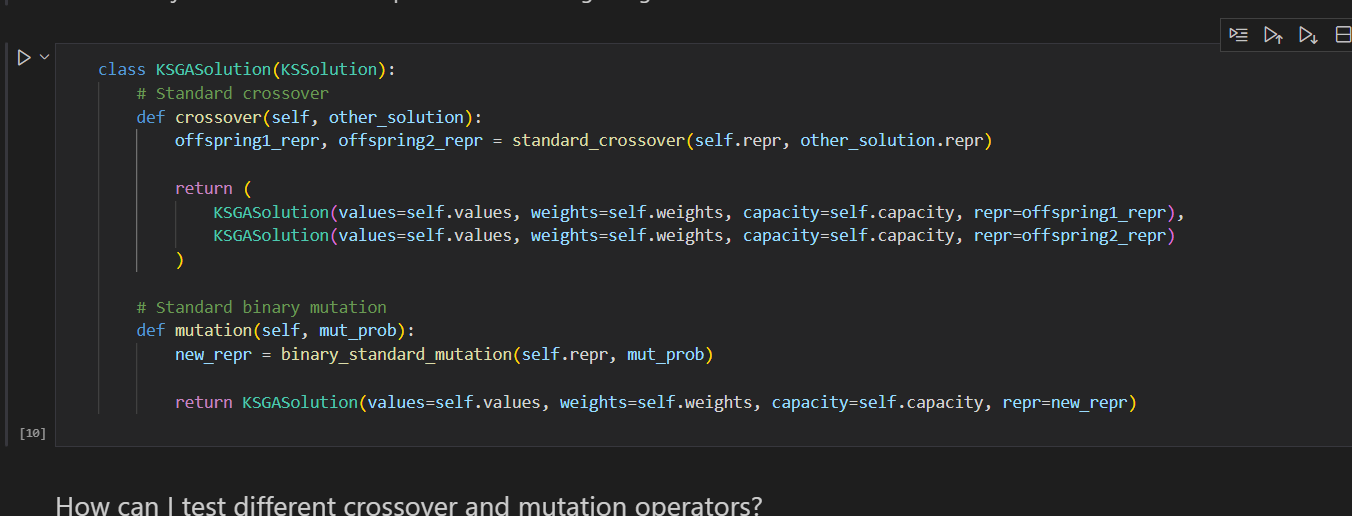

In [670]:
# class SportsLeagueGASolution(SportsLeagueSolution):
#     # crossover
#     def crossover(self, other_solution):
#         offspring1_repr, offspring2_repr = standard_crossover_with_position_repair(
#             self.repr, other_solution.repr, self.players_df
#         )

#         return (
#             SportsLeagueGASolution(repr=offspring1_repr),
#             SportsLeagueGASolution(repr=offspring2_repr)
#         )

#     # mutation
#     def mutation(self, mut_prob=0):
#         # if random.random() < mut_prob:
#         #     # Perform some actual mutation on self.repr
#         #     mutated_repr = mutate_team_structure(self.repr)
#         #     return SportsLeagueGASolution(repr=mutated_repr)
#         # else:
#         #     return deepcopy(self)
#         pass

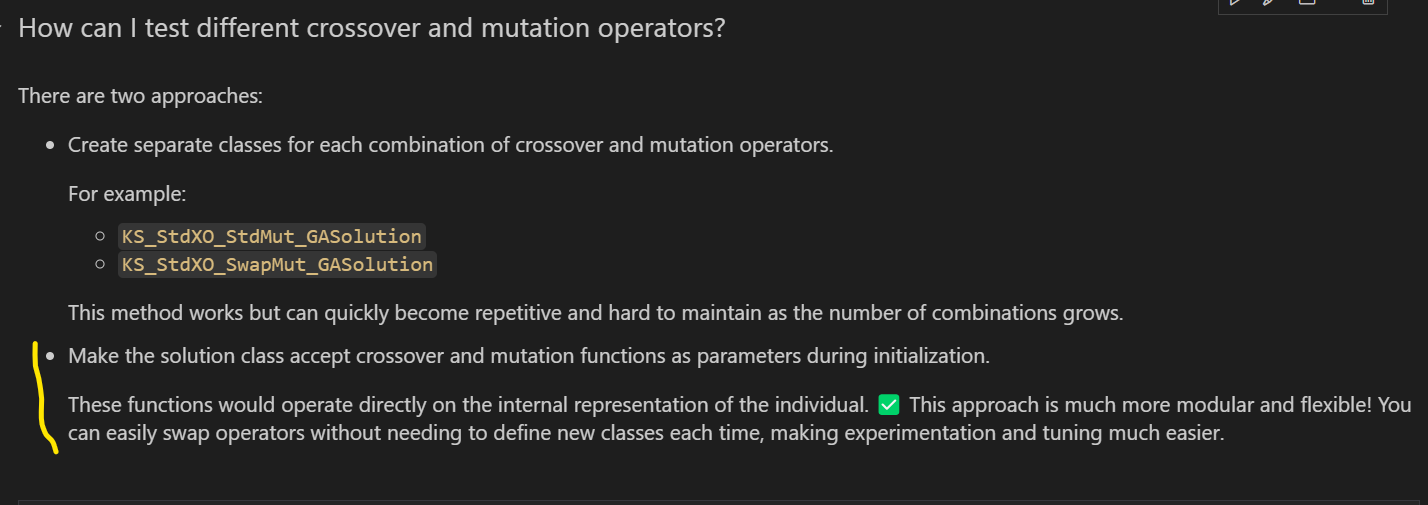

* new function like the one in class

In [166]:
class SportsLeagueGASolution(SportsLeagueSolution):

    def __init__(self, mutation_function, crossover_function,repr = None): # mutation_function: Callable, crossover_function: Callable
        super().__init__(players_df=df_sorted,repr=repr)

        # Save as attributes for access in methods
        self.mutation_function = mutation_function
        self.crossover_function = crossover_function


    # crossover
    def crossover(self, other_solution):
        # Apply crossover function to self representation and other solution representation
        offspring1_repr, offspring2_repr = self.crossover_function(self.repr, other_solution.repr, df_sorted)

        return (
            SportsLeagueGASolution(repr=offspring1_repr,
                                   mutation_function=self.mutation_function,
                                   crossover_function=self.crossover_function),
            SportsLeagueGASolution(repr=offspring2_repr,
                                   mutation_function=self.mutation_function,
                                   crossover_function=self.crossover_function)
        )


    # mutation
    def mutation(self, mut_prob):
        if random.random() < mut_prob:
             # Perform some actual mutation on self.repr
             mutated_repr = self.mutation_function(self)
             return SportsLeagueGASolution(repr=mutated_repr.repr,
                                          mutation_function=self.mutation_function,
                                          crossover_function=self.crossover_function)
        else:
             return deepcopy(self)
        

In [254]:
POP_SIZE = 50
initial_population = [
    SportsLeagueGASolution(mutation_function=player_role_left_shift_mutation, crossover_function=standard_crossover_with_position_repair)
    for _ in range(POP_SIZE)
]
initial_population

[[[0, 12, 13, 16, 18, 29, 25], [3, 5, 10, 19, 17, 34, 26], [4, 11, 7, 22, 23, 31, 28], [1, 9, 14, 15, 20, 30, 32], [2, 8, 6, 21, 24, 27, 33]],
 [[1, 5, 6, 20, 18, 25, 33], [2, 13, 9, 22, 17, 34, 30], [3, 11, 14, 15, 23, 32, 29], [0, 10, 8, 16, 24, 28, 26], [4, 7, 12, 19, 21, 31, 27]],
 [[1, 11, 5, 19, 21, 33, 30], [0, 8, 13, 22, 20, 34, 25], [4, 9, 7, 17, 15, 28, 27], [2, 6, 10, 18, 16, 26, 29], [3, 14, 12, 23, 24, 31, 32]],
 [[3, 10, 6, 18, 19, 32, 29], [1, 12, 5, 22, 23, 30, 31], [2, 9, 8, 17, 16, 25, 33], [4, 14, 11, 15, 24, 28, 26], [0, 7, 13, 21, 20, 27, 34]],
 [[3, 6, 12, 22, 24, 29, 31], [2, 5, 14, 21, 23, 25, 30], [1, 11, 8, 15, 19, 28, 32], [0, 10, 9, 20, 18, 33, 27], [4, 7, 13, 17, 16, 26, 34]],
 [[2, 9, 14, 21, 24, 31, 29], [3, 6, 5, 15, 20, 25, 33], [0, 13, 10, 23, 18, 32, 27], [1, 11, 8, 16, 17, 34, 30], [4, 7, 12, 19, 22, 26, 28]],
 [[1, 5, 6, 19, 22, 34, 25], [3, 7, 12, 24, 15, 31, 27], [0, 13, 14, 18, 16, 29, 26], [2, 9, 11, 20, 23, 30, 28], [4, 8, 10, 21, 17, 32, 33]],

In [255]:
best_solution = genetic_algorithm(
     initial_population=initial_population,
     selection_algorithm=tournament_selection,
     max_gen=100,
     maximization=False,
     verbose=True,
     elitism=True,) 

-------------- Generation: 1 --------------
Selected individuals:
[[4, 6, 7, 20, 18, 26, 28], [1, 14, 9, 17, 22, 34, 29], [3, 5, 8, 24, 21, 31, 30], [2, 10, 13, 23, 19, 27, 33], [0, 12, 11, 16, 15, 25, 32]]
[[3, 11, 12, 22, 24, 25, 28], [2, 8, 10, 15, 17, 30, 31], [1, 7, 14, 18, 23, 32, 34], [4, 13, 5, 19, 16, 27, 29], [0, 9, 6, 21, 20, 26, 33]]
Applied crossover
Offspring:
[[3, 12, 11, 22, 24, 25, 28], [2, 8, 10, 15, 17, 30, 31], [1, 7, 14, 18, 23, 32, 34], [4, 13, 5, 19, 16, 27, 29], [0, 9, 6, 21, 20, 26, 33]]
[[4, 6, 7, 20, 18, 26, 28], [1, 14, 9, 17, 22, 34, 29], [3, 5, 8, 24, 21, 31, 30], [2, 10, 13, 23, 19, 27, 33], [0, 12, 11, 16, 15, 25, 32]]
First mutated individual: [[3, 12, 11, 17, 18, 25, 28], [2, 8, 10, 23, 19, 30, 31], [1, 7, 14, 16, 21, 32, 34], [4, 13, 5, 20, 22, 27, 29], [0, 9, 6, 24, 15, 26, 33]]
Second mutated individual: [[4, 6, 7, 20, 18, 26, 28], [1, 14, 9, 17, 22, 34, 29], [3, 5, 8, 24, 21, 31, 30], [2, 10, 13, 23, 19, 27, 33], [0, 12, 11, 16, 15, 25, 32]]
Select

In [256]:
print("Best solution:", best_solution[0])
print("Fitness:", best_solution[1][-1])

Best solution: [[3, 10, 5, 19, 15, 32, 25], [4, 7, 12, 22, 17, 31, 27], [0, 13, 14, 18, 21, 29, 33], [2, 9, 11, 20, 23, 30, 28], [1, 8, 6, 16, 24, 26, 34]]
Fitness: 0.13997084244474906


In [257]:
best_solution[1]

[0.43705881545081143,
 0.4276179870598771,
 0.16659862556700822,
 0.16659862556700822,
 0.16659862556700822,
 0.16659862556700822,
 0.16659862556700822,
 0.16659862556700822,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084244474906,
 0.13997084

<Axes: >

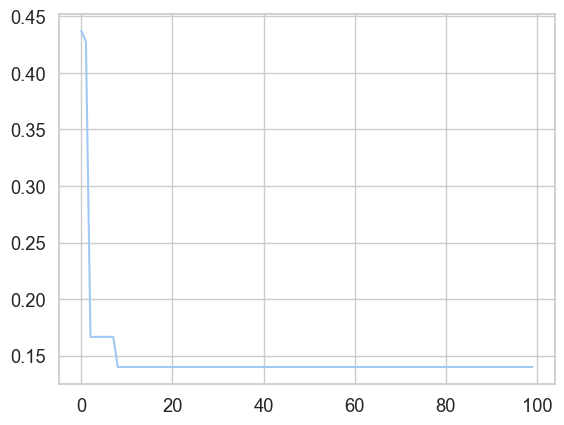

In [258]:
sns.lineplot(best_solution[1])

# Analise de resultados 

In [95]:
import itertools

In [260]:
POP_SIZE = 5
GENERATIONS = 5

grid_params = {
    "crossover": [
        {
            "function": standard_crossover_with_position_repair,
            "xo_prob": 0.8
        },
        {
            "function": crossover_by_position_dual,
            "xo_prob": 0.8
        }
    ],
    "mutation": [
        {
            "function": player_role_left_shift_mutation,
            "mut_prob": 0.8
        },
        {
            "function": role_shuffle_mutation,
            "mut_prob": 0.5
        },
        {
            "function": player_swap_mutation,
            "mut_prob":0.5
        }
    ],
    "elitism": [True, False]
}

fitness_dfs = {}

# Generate all combinations of the grid parameters
grid = list(itertools.product(grid_params["crossover"], grid_params["mutation"], grid_params["elitism"]))

for crossover_cfg, mutation_cfg, elitism in grid:
    # Create empty dataframe for each configuration
    # Columns have the fitness in each generation, rows will have results for each run
    df = pd.DataFrame(columns=range(GENERATIONS)) # Shape will be 30 x 200

    # Get crossover and mutation functions and probabilities from the grid
    crossover_function = crossover_cfg["function"]
    xo_prob = crossover_cfg["xo_prob"]
    mutation_function = mutation_cfg["function"]
    mut_prob = mutation_cfg["mut_prob"]

    config_results = []

    # Run for 30 times
    for run_nr in range(30):
        print("run_nr = ", run_nr)
        _, fitness_over_gens = genetic_algorithm(
            initial_population=[
                SportsLeagueGASolution(
                    mutation_function=mutation_function,
                    crossover_function=crossover_function
                ) for _ in range(POP_SIZE)
            ],
            max_gen=GENERATIONS,
            selection_algorithm=tournament_selection,
            xo_prob=xo_prob,
            mut_prob=mut_prob,
            elitism=elitism
        )
        config_results.append(fitness_over_gens)

        df.loc[run_nr] = fitness_over_gens

    # Create a label for the configuration
    config_label = (
        f"{crossover_function.__name__}{xo_prob}_"
        f"{mutation_function.__name__}{mut_prob}_elitism={elitism}"
    )
    print(config_label)

    # Save configuration results in the dictionary
    fitness_dfs[config_label] = df



run_nr =  0
run_nr =  1
run_nr =  2
run_nr =  3
run_nr =  4
run_nr =  5
run_nr =  6
run_nr =  7
run_nr =  8
run_nr =  9
run_nr =  10
run_nr =  11
run_nr =  12
run_nr =  13
run_nr =  14
run_nr =  15
run_nr =  16
run_nr =  17
run_nr =  18
run_nr =  19
run_nr =  20
run_nr =  21
run_nr =  22
run_nr =  23
run_nr =  24
run_nr =  25
run_nr =  26
run_nr =  27
run_nr =  28
run_nr =  29
standard_crossover_with_position_repair0.8_player_role_left_shift_mutation0.8_elitism=True
run_nr =  0
run_nr =  1
run_nr =  2
run_nr =  3
run_nr =  4
run_nr =  5
run_nr =  6
run_nr =  7
run_nr =  8
run_nr =  9
run_nr =  10
run_nr =  11
run_nr =  12
run_nr =  13
run_nr =  14
run_nr =  15
run_nr =  16
run_nr =  17
run_nr =  18
run_nr =  19
run_nr =  20
run_nr =  21
run_nr =  22
run_nr =  23
run_nr =  24
run_nr =  25
run_nr =  26
run_nr =  27
run_nr =  28
run_nr =  29
standard_crossover_with_position_repair0.8_player_role_left_shift_mutation0.8_elitism=False
run_nr =  0
run_nr =  1
run_nr =  2
run_nr =  3
run_nr = 

In [261]:
fitness_dfs

{'standard_crossover_with_position_repair0.8_player_role_left_shift_mutation0.8_elitism=True':            0         1         2         3         4
 0   0.758086  0.758086  0.758086  0.758086  0.758086
 1   0.189521  0.189521  0.189521  0.189521  0.189521
 2   0.741757  0.713714  0.472941  0.455354  0.455354
 3   0.595219  0.595219  0.588322  0.588322  0.588322
 4   0.354562  0.354562  0.318158  0.318158  0.318158
 5   0.376883  0.376883  0.376883  0.376883  0.376883
 6   0.330738  0.330738  0.330738  0.330738  0.330738
 7   0.376883  0.376883  0.376883  0.376883  0.376883
 8   0.408082  0.408082  0.408082  0.408082  0.408082
 9   0.514286  0.514286  0.514286  0.481494  0.481494
 10  0.446300  0.305059  0.305059  0.305059  0.305059
 11  0.914286  0.567127  0.567127  0.567127  0.567127
 12  0.567127  0.455354  0.455354  0.209956  0.209956
 13  0.774070  0.774070  0.774070  0.713714  0.713714
 14  1.051335  0.702183  0.702183  0.702183  0.537568
 15  0.291373  0.291373  0.291373  0.29137

In [262]:
print(list(fitness_dfs.keys()))

['standard_crossover_with_position_repair0.8_player_role_left_shift_mutation0.8_elitism=True', 'standard_crossover_with_position_repair0.8_player_role_left_shift_mutation0.8_elitism=False', 'standard_crossover_with_position_repair0.8_role_shuffle_mutation0.5_elitism=True', 'standard_crossover_with_position_repair0.8_role_shuffle_mutation0.5_elitism=False', 'standard_crossover_with_position_repair0.8_player_swap_mutation0.5_elitism=True', 'standard_crossover_with_position_repair0.8_player_swap_mutation0.5_elitism=False', 'crossover_by_position_dual0.8_player_role_left_shift_mutation0.8_elitism=True', 'crossover_by_position_dual0.8_player_role_left_shift_mutation0.8_elitism=False', 'crossover_by_position_dual0.8_role_shuffle_mutation0.5_elitism=True', 'crossover_by_position_dual0.8_role_shuffle_mutation0.5_elitism=False', 'crossover_by_position_dual0.8_player_swap_mutation0.5_elitism=True', 'crossover_by_position_dual0.8_player_swap_mutation0.5_elitism=False']


In [263]:
fitness_dfs['standard_crossover_with_position_repair0.8_player_role_left_shift_mutation0.8_elitism=True']

,0,1,2,3,4
0,0.758086,0.758086,0.758086,0.758086,0.758086
1,0.189521,0.189521,0.189521,0.189521,0.189521
2,0.741757,0.713714,0.472941,0.455354,0.455354
3,0.595219,0.595219,0.588322,0.588322,0.588322
4,0.354562,0.354562,0.318158,0.318158,0.318158
5,0.376883,0.376883,0.376883,0.376883,0.376883
6,0.330738,0.330738,0.330738,0.330738,0.330738
7,0.376883,0.376883,0.376883,0.376883,0.376883
8,0.408082,0.408082,0.408082,0.408082,0.408082
9,0.514286,0.514286,0.514286,0.481494,0.481494


In [264]:
import matplotlib.pyplot as plt

In [265]:
def plot_fitness_over_gen(fitness_dfs: dict[str, pd.DataFrame]):
    """
    
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    handles, labels = [], []

    for config_name, df in fitness_dfs.items():
        mean_fitness = df.mean(axis=0)
        median_fitness = df.median(axis=0)
        
        line1, = axes[0].plot(mean_fitness.index, mean_fitness.values, label=config_name)
        axes[1].plot(median_fitness.index, median_fitness.values, label=config_name)

        handles.append(line1)
        labels.append(config_name)

    axes[0].set_title("Mean Fitness Across Generations")
    axes[1].set_title("Median Fitness Across Generations")

    for ax in axes:
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.grid(True)

    # Shared boxed legend below
    legend = fig.legend(
        handles,
        labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,
        frameon=True,
        borderpad=1
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()

In [176]:
fitness_dfs.pop("standard_crossover_with_position_repair0.8_role_shuffle_mutation0.2_elitism=False", None)


,0,1,2,3,4
0,8.590455e-01,1.000000e+09,1.000000e+09,1.750568e+00,1.243432e+00
1,1.000000e+09,7.740696e-01,8.201543e-01,8.201543e-01,9.663734e-01
2,6.785338e-01,8.446712e-01,1.000000e+09,1.000000e+09,4.553536e-01
3,7.793247e-01,8.684962e-01,1.344376e+00,1.062919e+00,1.147846e+00
4,1.019804e+00,9.995918e-01,1.000000e+09,1.000000e+09,1.000000e+09
5,6.477591e-01,9.275819e-01,1.126309e+00,3.658928e-01,3.658928e-01
6,1.066752e+00,6.963461e-01,6.845228e-01,1.000000e+09,1.011767e+00
7,8.300479e-01,1.066752e+00,1.269421e+00,8.398251e-01,8.824826e-01
8,7.137141e-01,4.814943e-01,8.000000e-01,1.140712e+00,1.179415e+00
9,1.688859e+00,9.705879e-01,1.259738e+00,1.175949e+00,9.789624e-01


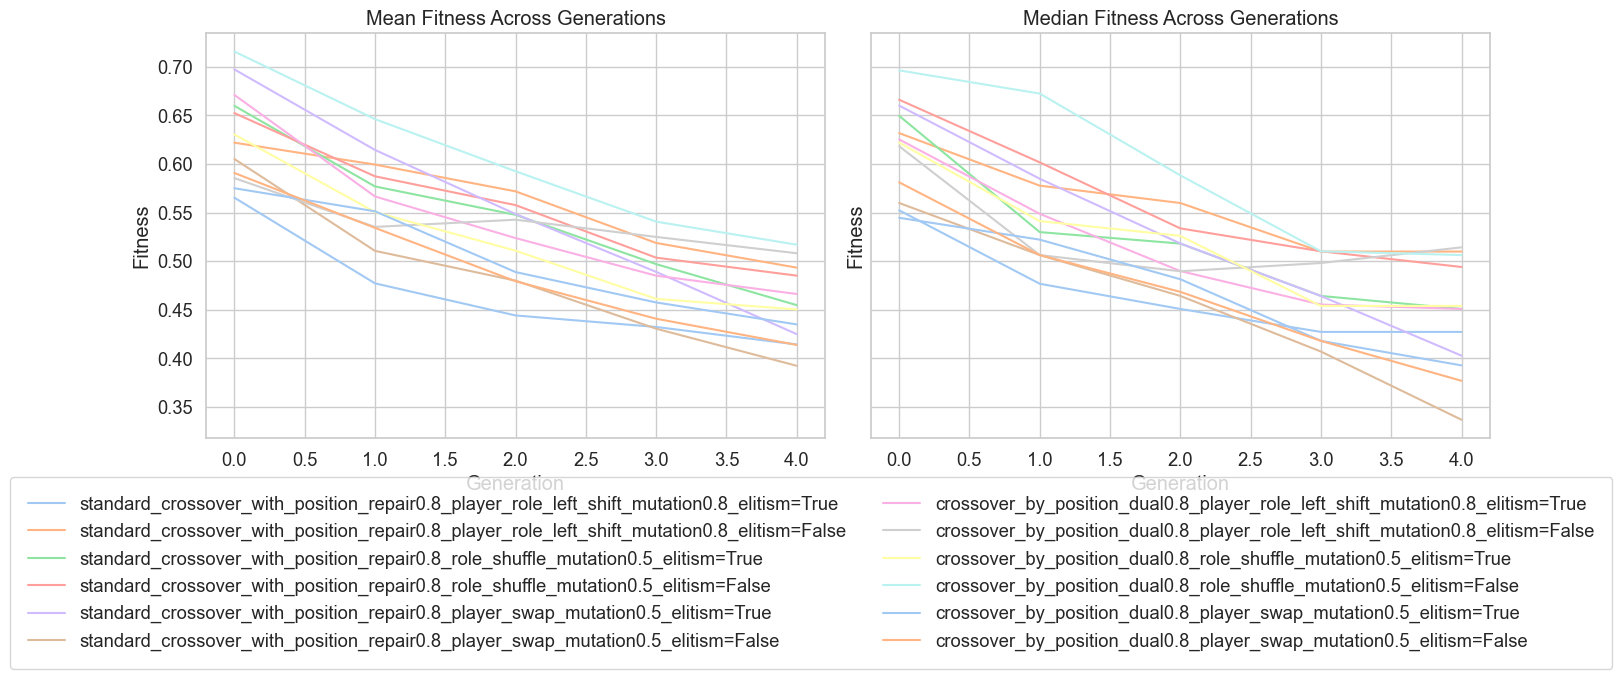

In [266]:
plot_fitness_over_gen(fitness_dfs)

### Isolating the Impact of Crossover and Mutation

In [267]:
crossover_names = ["standard_crossover_with_position_repair", "crossover_by_position_dual"]
mutation_names = ["player_role_left_shift_mutation", "player_swap_mutation","role_shuffle_mutation"]

crossover_fit_dfs = {}
mutation_fit_dfs = {}

# Combine all isolated runs using a given crossover
for crossover_name in crossover_names:
    dfs_to_concat = []
    for df_name, df in fitness_dfs.items():
        if crossover_name in df_name:
            dfs_to_concat.append(df)

    crossover_fit_dfs[crossover_name] = pd.concat(dfs_to_concat, axis=0).reset_index(drop=True)

# Combine all isolated runs using a given mutation
for mutation_name in mutation_names:
    dfs_to_concat = []
    for df_name, df in fitness_dfs.items():
        if mutation_name in df_name:
            dfs_to_concat.append(df)
    mutation_fit_dfs[mutation_name] = pd.concat(dfs_to_concat, axis=0).reset_index(drop=True)


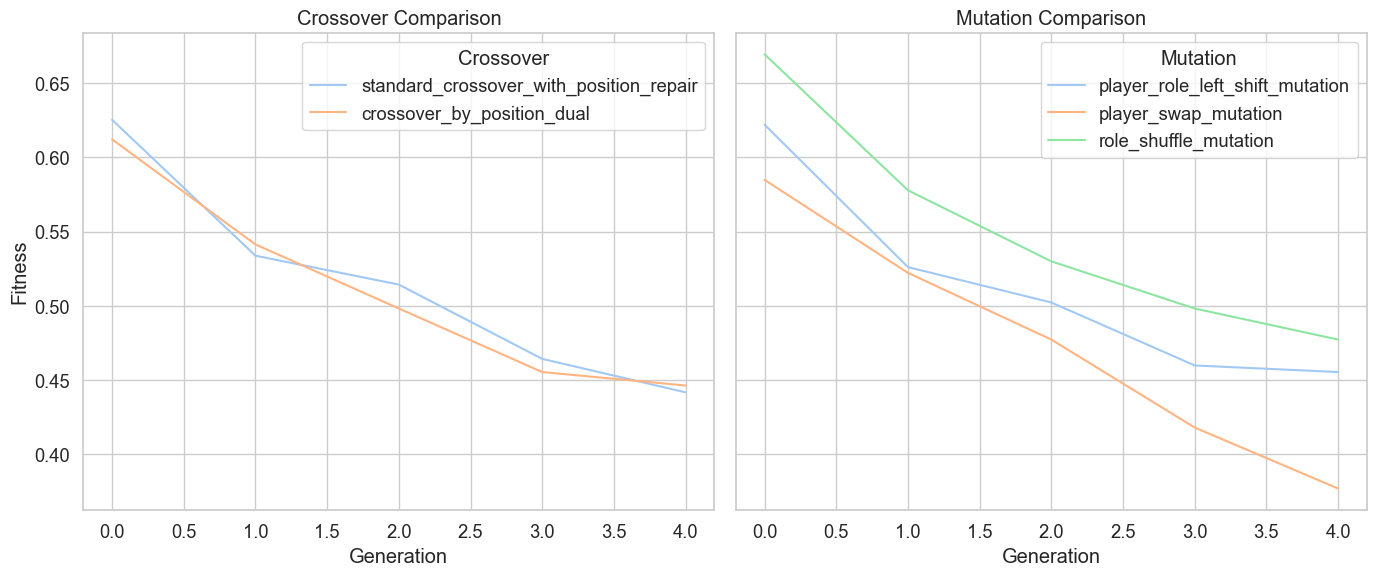

In [268]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot crossover results
for name, df in crossover_fit_dfs.items():
    mean_fitness = df.median(axis=0)
    axes[0].plot(mean_fitness.index, mean_fitness.values, label=name)

axes[0].set_title("Crossover Comparison")
axes[0].set_xlabel("Generation")
axes[0].set_ylabel("Fitness")
axes[0].legend(title="Crossover")
axes[0].grid(True)

# Plot mutation results
for name, df in mutation_fit_dfs.items():
    mean_fitness = df.median(axis=0)
    axes[1].plot(mean_fitness.index, mean_fitness.values, label=name)

axes[1].set_title("Mutation Comparison")
axes[1].set_xlabel("Generation")
axes[1].legend(title="Mutation")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [269]:
crossover_names = ["standard_crossover_with_position_repair", "crossover_by_position_dual"]
mutation_names = ["player_role_left_shift_mutation", "player_swap_mutation","role_shuffle_mutation"]

crossover_medians = {k: [] for k in crossover_names}
mutation_medians = {k: [] for k in mutation_names}

for df_name, df in fitness_dfs.items():
    for crossover_name in crossover_names:
        if crossover_name in df_name:
            # Calculate median best fitness over generations for configuration using this crossover
            crossover_medians[crossover_name].append(df.median(axis=0).values)
    for mutation_name in mutation_names:
        if mutation_name in df_name:
            # Calculate median best fitness over generations for configuration using this mutation
            mutation_medians[mutation_name].append(df.median(axis=0).values)

# Compute final median curves (median of medians across configurations)
crossover_curves = {k: np.median(v, axis=0) for k, v in crossover_medians.items()}
mutation_curves = {k: np.median(v, axis=0) for k, v in mutation_medians.items()}

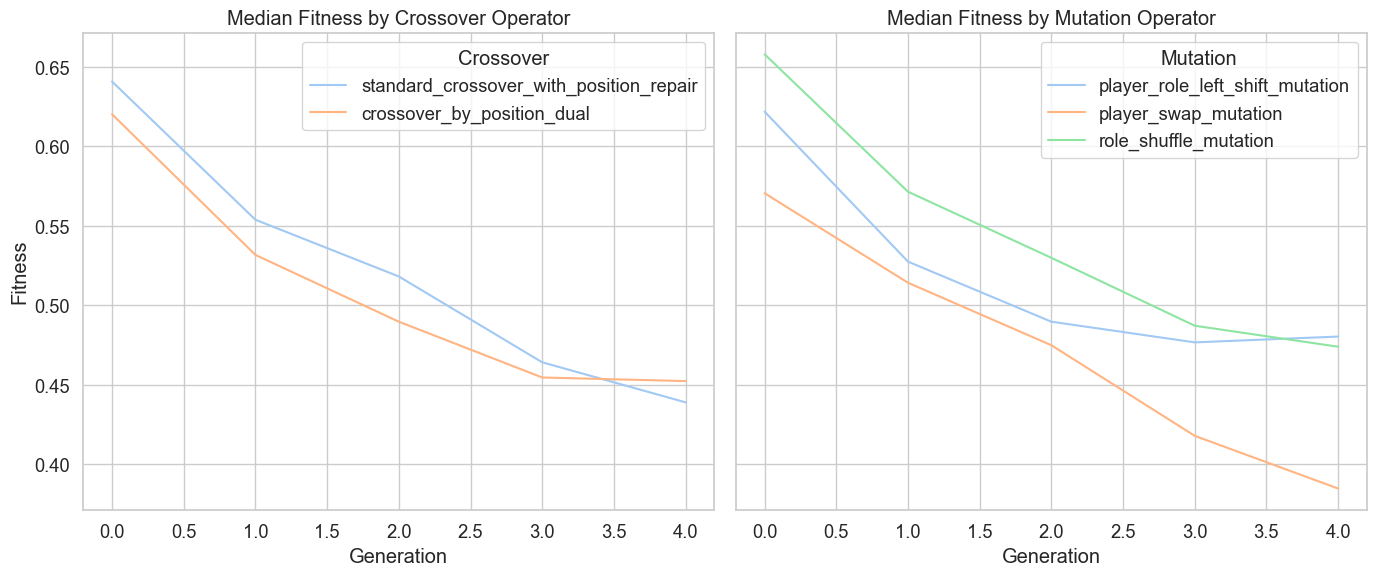

In [270]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot crossover
for name, curve in crossover_curves.items():
    axes[0].plot(range(len(curve)), curve, label=name)
axes[0].set_title("Median Fitness by Crossover Operator")
axes[0].set_xlabel("Generation")
axes[0].set_ylabel("Fitness")
axes[0].legend(title="Crossover")
axes[0].grid(True)

# Plot mutation
for name, curve in mutation_curves.items():
    axes[1].plot(range(len(curve)), curve, label=name)
axes[1].set_title("Median Fitness by Mutation Operator")
axes[1].set_xlabel("Generation")
axes[1].legend(title="Mutation")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [271]:
grid_params = {
    "xo_prob": [random.uniform(0, 1/3), random.uniform(1/3, 2/3), random.uniform(2/3, 1)],
    "mut_prob": [random.uniform(0, 1/3), random.uniform(1/3, 2/3), random.uniform(2/3, 1)]
}

finetune_fitness_results = {}

for xo_prob in grid_params["xo_prob"]:
    print("xo_prob =", xo_prob)
    for mut_prob in grid_params["mut_prob"]:
        print("mut_prob = ", mut_prob)
        config_results = []

        for run_nr in range(30):
            print("run_nr =", run_nr)
            best_solution, _ = genetic_algorithm(
                initial_population=[
                SportsLeagueGASolution(
                    mutation_function=mutation_function,
                    crossover_function=crossover_function
                ) for _ in range(POP_SIZE)
                ],
                max_gen=GENERATIONS,
                selection_algorithm=ranking_selection,
                xo_prob=xo_prob,
                mut_prob=mut_prob,
                elitism=True
            )
            config_results.append(best_solution.fitness())

        # Create a label for the config
        config_label = f"xo_prob={round(xo_prob, 2)}_mut_prob={round(mut_prob, 2)}"
        print(config_label)
    
        finetune_fitness_results[config_label] = config_results

xo_prob = 0.22570285477735555
mut_prob =  0.015944911948756836
run_nr = 0
run_nr = 1
run_nr = 2
run_nr = 3
run_nr = 4
run_nr = 5
run_nr = 6
run_nr = 7
run_nr = 8
run_nr = 9
run_nr = 10
run_nr = 11
run_nr = 12
run_nr = 13
run_nr = 14
run_nr = 15
run_nr = 16
run_nr = 17
run_nr = 18
run_nr = 19
run_nr = 20
run_nr = 21
run_nr = 22
run_nr = 23
run_nr = 24
run_nr = 25
run_nr = 26
run_nr = 27
run_nr = 28
run_nr = 29
xo_prob=0.23_mut_prob=0.02
mut_prob =  0.44788105684013285
run_nr = 0
run_nr = 1
run_nr = 2
run_nr = 3
run_nr = 4
run_nr = 5
run_nr = 6
run_nr = 7
run_nr = 8
run_nr = 9
run_nr = 10
run_nr = 11
run_nr = 12
run_nr = 13
run_nr = 14
run_nr = 15
run_nr = 16
run_nr = 17
run_nr = 18
run_nr = 19
run_nr = 20
run_nr = 21
run_nr = 22
run_nr = 23
run_nr = 24
run_nr = 25
run_nr = 26
run_nr = 27
run_nr = 28
run_nr = 29
xo_prob=0.23_mut_prob=0.45
mut_prob =  0.9617599800694258
run_nr = 0
run_nr = 1
run_nr = 2
run_nr = 3
run_nr = 4
run_nr = 5
run_nr = 6
run_nr = 7
run_nr = 8
run_nr = 9
run_nr = 1

In [183]:
import seaborn as sns

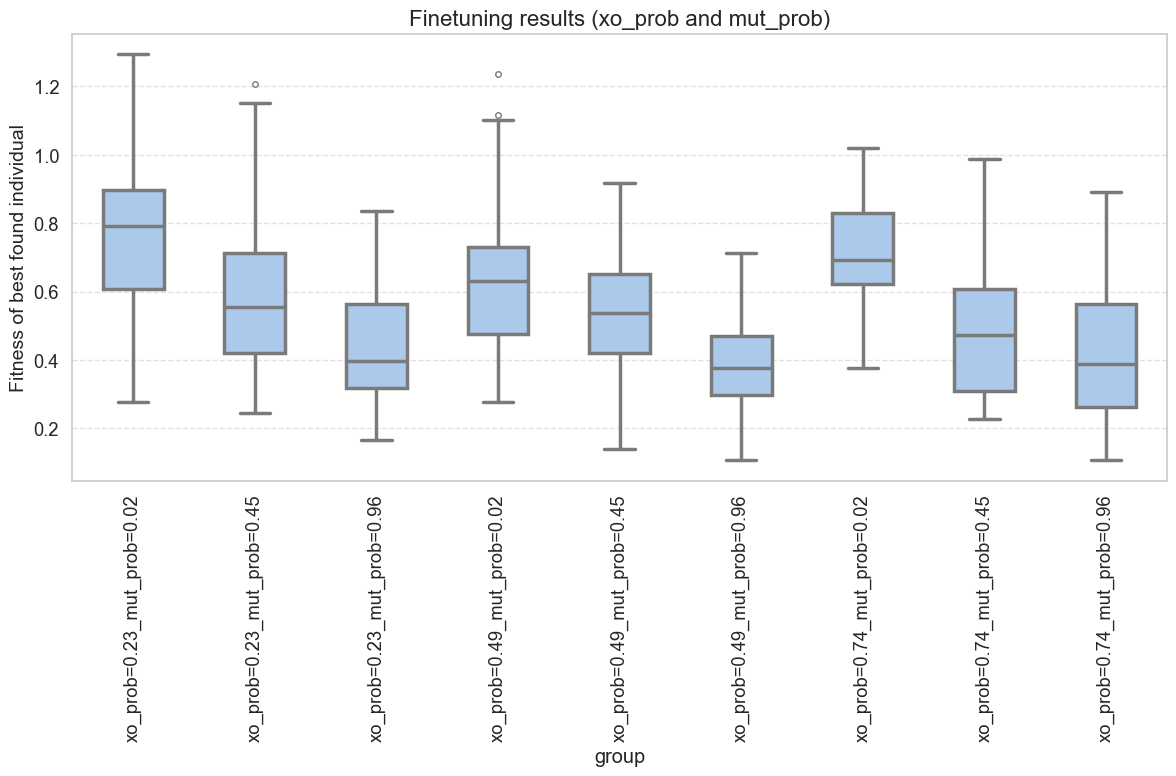

In [272]:
# Convert the results into a long-format DataFrame for Seaborn
data = []
for config_label, fitness_values in finetune_fitness_results.items():
    for value in fitness_values:
        data.append({
            'value': value,
            'group': config_label
        })

df_long = pd.DataFrame(data)

# Set a beautiful theme using Seaborn
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)

# Create the plot
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='group', y='value', data=df_long, width=0.5, linewidth=2.5, fliersize=4)

# Titles and labels
plt.title('Finetuning results (xo_prob and mut_prob)', fontsize=16)
plt.ylabel('Fitness of best found individual', fontsize=14)
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
